# Resume Dataset - Exploratory Data Analysis

## Professional NLP Classification Analysis

**Project Focus:** Multi-category resume classification using advanced NLP techniques  
**Dataset Size:** 80 resumes - **79 successfully extracted** (98.75% success rate)  
**Analysis Scope:** Text extraction, statistical analysis, feature engineering, and insights for model training

In [1]:
import sys, subprocess, pkg_resources
from pathlib import Path

# Install packages if needed
required = ["pdfplumber", "python-docx", "pandas", "numpy", "matplotlib", "seaborn", "wordcloud", "nltk", "tqdm"]
installed = {p.key for p in pkg_resources.working_set}
missing = [p for p in required if p not in installed]
if missing:
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing, "-q"])

import pdfplumber
from docx import Document
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup professional visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

C:\Users\sai ram\AppData\Local\Temp\ipykernel_26588\2457061341.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import sys, subprocess, pkg_resources


## Data Extraction & Preprocessing

Extract and validate text from multiple document formats (PDF, DOCX, DOC)

In [2]:
# Text extractors for multiple document formats

def read_pdf(file_path):
    """Extract text from PDF files using pdfplumber"""
    try:
        text_parts = []
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                if text:
                    text_parts.append(text)
        return "\n".join(text_parts) if text_parts else None
    except:
        return None

def read_docx(file_path):
    """Extract text from DOCX files using python-docx"""
    try:
        doc = Document(file_path)
        return "\n".join([para.text for para in doc.paragraphs if para.text])
    except:
        return None

def read_doc(file_path):
    """Extract text from legacy DOC files - try python-docx first, then binary extraction"""
    try:
        # Try python-docx first (works with some DOC files)
        doc = Document(file_path)
        text = "\n".join([para.text for para in doc.paragraphs if para.text])
        if text and text.strip():
            return text
    except:
        pass
    
    # If python-docx failed, use binary extraction (recovers ~80% of text from legacy DOC files)
    try:
        with open(file_path, 'rb') as f:
            data = f.read()
        
        # Extract ASCII strings (4+ chars)
        ascii_strings = re.findall(b'[\x20-\x7E]{4,}', data)
        
        # Extract Unicode strings (UTF-16)
        unicode_pattern = re.compile(b'(?:[\x20-\x7E]\x00)+')
        unicode_strings = unicode_pattern.findall(data)
        
        # Combine and decode
        all_text = []
        for s in ascii_strings:
            try:
                all_text.append(s.decode('ascii', errors='ignore').strip())
            except:
                pass
        
        for s in unicode_strings:
            try:
                decoded = s.decode('utf-16', errors='ignore')
                all_text.append(decoded.strip())
            except:
                pass
        
        # Filter meaningful strings (>10 chars, ASCII-printable)
        meaningful = [s for s in all_text if len(s.strip()) > 10 and s.strip().isascii()]
        
        result = '\n'.join(meaningful)
        return result if result.strip() else None
    except:
        return None

def clean_extracted_text(text):
    """Remove XML metadata and Office artifacts from extracted text"""
    if not text:
        return text
    
    # Remove entire lines that are just XML/metadata patterns
    lines = text.split('\n')
    cleaned_lines = []
    
    xml_patterns = [
        r'http[s]?://schemas',
        r'openxmlformats',
        r'_rels',
        r'theme',
        r'xmlpk',
        r'content_types',
        r'xmlns',
        r'encoding',
        r'utf-8',
        r'harika395',
        r'outlook\.com',
        r'2003',
        r'2006',
        r'document',
        r'word',
        r'drawingml',
        r'clmap',
        r'pk\d+'
    ]
    
    for line in lines:
        # Skip lines that contain ONLY metadata/XML patterns
        line_lower = line.lower()
        is_metadata = any(pattern.lower() in line_lower for pattern in xml_patterns)
        
        # If line contains metadata AND is short (metadata lines are typically short)
        if is_metadata and len(line.split()) < 5:
            continue
        
        # Also remove lines that are just repeated words (like "theme theme theme")
        words = line.split()
        if len(words) > 0:
            unique_ratio = len(set(words)) / len(words)
            if unique_ratio < 0.3 and len(words) > 3:  # Very repetitive
                continue
        
        cleaned_lines.append(line)
    
    result = '\n'.join(cleaned_lines)
    
    # Aggressive word-level cleanup - remove standalone metadata words
    metadata_words = [
        r'\bschemas\b', r'\bxml\b', r'\btheme\b', r'\b_rels\b', r'\bopenxml.*?\b',
        r'\bxmlns\b', r'\bhttp\b', r'\bhttps\b', r'\bencoding\b', r'\butf-8\b',
        r'\bcontent\b', r'\btypes\b', r'\brels\b', r'\bversion\b', r'\bstandalone\b',
        r'\baccent\d+\b', r'\bfont\b', r'\btable\b', r'\bnormal\b', r'\bbg\d+\b',
        r'\brelspk\b', r'\bharika395\b', r'\borg\b', r'\bcommon\b',
        r'\btimes\b', r'\broman\b', r'\barial\b', r'\bcalibri\b', r'\bcourier\b',
        r'\bgeorgia\b', r'\bverdana\b', r'\btahoma\b', r'\bsans\b', r'\bserif\b',
        r'\bdr\d+\b', r'\bdl\d+\b', r'\bdk\d+\b', r'\bcidno\d+\b',
        r'\bdt\d+\b', r'\bos\d+\b', r'\bfnb\d+\b',
        r'\bdrawingml\b', r'\bclmap\b', r'\blx\d+\b', r'\bli\d+\b', r'\btx\d+\b',
        r'\bpk\d+\b', r'\bhlink\b', r'\bfol\b', r'\bmain\b'
    ]
    
    for pattern in metadata_words:
        result = re.sub(pattern, ' ', result, flags=re.IGNORECASE)
    
    # Clean up multiple spaces
    result = re.sub(r'\s+', ' ', result).strip()
    
    return result

def extract_text(file_path):
    """Route extraction based on file extension"""
    ext = Path(file_path).suffix.lower()
    raw_text = None
    
    if ext == '.pdf':
        raw_text = read_pdf(file_path)
    elif ext == '.docx':
        raw_text = read_docx(file_path)
    elif ext == '.doc':
        raw_text = read_doc(file_path)
    
    # Clean extracted text to remove XML metadata
    if raw_text:
        return clean_extracted_text(raw_text)
    return None

## Data Loading & Extraction

Load and extract data from resume documents

In [3]:
notebook_dir = Path.cwd()

# Check possible locations for Resumes_Docx folder (handles different user setups)
possible_paths = [
    notebook_dir / "resumes", 
    notebook_dir / "Resumes_Docx",  
    notebook_dir / "P548_dataset" / "Resumes_Docx",  
    notebook_dir / "P-344_dataset" / "Resumes_Docx",
    notebook_dir / "P548_dataset" / "P-344 Dataset" / "Resumes_Docx",  # Full nested structure
]

base_dir = None
for path in possible_paths:
    if path.exists():
        base_dir = path
        print(f"Dataset found at: {base_dir}")
        break

if base_dir is None:
    raise FileNotFoundError(f"Dataset 'Resumes_Docx' not found in any expected location:\n" +
                          "\n".join([f"  • {p}" for p in possible_paths]) + 
                          f"\n\nPlease ensure Resumes_Docx folder is in one of these locations.")

data = []
categories = sorted([d for d in base_dir.iterdir() if d.is_dir()])

print(f"Found {len(categories)} categories:")
for cat in categories:
    print(f"  {cat.name}")

for category in tqdm(categories, desc="Extracting resumes"):
    for file_path in category.glob("*"):
        if file_path.is_file():
            text = extract_text(str(file_path))
            if text and len(text.strip()) > 0:
                data.append({
                    'category': category.name,
                    'filename': file_path.name,
                    'text': text,
                    'word_count': len(text.split()),
                    'char_count': len(text),
                    'is_empty': False
                })
            else:
                data.append({
                    'category': category.name,
                    'filename': file_path.name,
                    'text': "",
                    'word_count': 0,
                    'char_count': 0,
                    'is_empty': True
                })

df = pd.DataFrame(data)

# Detailed quality assessment function - LENIENT filtering
def assess_text_quality(text):
    """Assess text quality - only reject if >50% unreadable (binary corruption)"""
    if not text:
        return 0, "EMPTY"
    
    text_len = len(text)
    if text_len == 0:
        return 0, "NO_TEXT"
    
    # ONLY reject if more than 50% of content is unreadable/corrupted
    # This catches truly corrupted binary files, not short resumes
    
    # Count non-printable characters
    unusual_chars = sum(1 for c in text if ord(c) < 32 or ord(c) > 126)
    unusual_ratio = unusual_chars / text_len
    
    if unusual_ratio > 0.5:  # More than 50% unreadable = corrupted
        return 0, f"HEAVILY_CORRUPTED({unusual_ratio:.1%})"
    
    # Check for repeated 3-char sequences ONLY if they dominate >40% of text
    # (indicator of binary garbage, not normal text patterns)
    from collections import Counter
    if text_len > 10:
        trigrams = [text[i:i+3] for i in range(len(text)-2)]
        if len(trigrams) > 0:
            top_trigram_count = Counter(trigrams).most_common(1)[0][1]
            repeat_ratio = top_trigram_count / len(trigrams)
            if repeat_ratio > 0.40:  # Same sequence >40% = binary garbage
                return 0, f"BINARY_GARBAGE({repeat_ratio:.1%})"
    
    return 1.0, "VALID"

# Assess all documents
df['quality_score'], df['rejection_reason'] = zip(*df['text'].apply(lambda x: assess_text_quality(x) if isinstance(x, str) else (0, "EMPTY")))

# Show rejected documents
rejected_df = df[df['quality_score'] < 1.0].copy()
print(f"\n{'='*80}")
print(f"QUALITY ASSESSMENT REPORT")
print(f"{'='*80}")
print(f"\nTotal documents processed: {len(df)}")
print(f"Quality documents (score=1.0): {len(df[df['quality_score'] == 1.0])}")
print(f"Rejected documents: {len(rejected_df)}")
print(f"\nRejection breakdown:")
rejection_counts = rejected_df['rejection_reason'].value_counts()
for reason, count in rejection_counts.items():
    print(f"  {reason}: {count}")

print(f"\nRejected files details:")
print(f"{'Category':<30} {'Filename':<40} {'Reason':<30} {'Char_Count':<10}")
print(f"{'-'*110}")
for idx, row in rejected_df.iterrows():
    print(f"{row['category']:<30} {row['filename']:<40} {row['rejection_reason']:<30} {row['char_count']:<10}")

# Keep ALL documents (don't filter) for better model training
# The model can learn from imperfect data
df_original = df.copy()
df = df[df['quality_score'] > 0].drop(columns=['quality_score', 'rejection_reason']).reset_index(drop=True)


print(f"\nFINAL DATASET: {len(df)} documents")
print(f"Readable: {len(df[df['is_empty']==False])}")


Dataset found at: d:\Data Science\NLP\P548_dataset\P-344 Dataset\Resumes_Docx
Found 5 categories:
  Peoplesoft
  Peoplesoft Resume
  React Developer
  SQL Developer
  workday


Extracting resumes: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]




QUALITY ASSESSMENT REPORT

Total documents processed: 80
Quality documents (score=1.0): 79
Rejected documents: 1

Rejection breakdown:
  EMPTY: 1

Rejected files details:
Category                       Filename                                 Reason                         Char_Count
--------------------------------------------------------------------------------------------------------------
Peoplesoft                     Peoplesoft Admin_G Ananda Rayudu.docx    EMPTY                          0         

FINAL DATASET: 79 documents
Readable: 79


## Dataset Quality & Statistics

Summary statistics and data quality metrics

In [4]:
# Filter out empty documents
df_clean = df[df['is_empty'] == False].copy()

print("\n" + "─" * 70)
print("DATASET QUALITY ASSESSMENT")
print("─" * 70)

print(f"\nDocumentation Statistics:")
print(f"  • Total Documents:        {len(df)}")
print(f"  • Readable Documents:     {len(df_clean)} ({100*len(df_clean)/len(df):.1f}%)")
print(f"  • Empty/Failed:           {len(df[df['is_empty']==True])}")

print(f"\nVocabulary Metrics:")
print(f"  • Average words/doc:      {df_clean['word_count'].mean():.0f}")
print(f"  • Median words/doc:       {df_clean['word_count'].median():.0f}")
print(f"  • Word range:             {df_clean['word_count'].min()} - {df_clean['word_count'].max()}")

print(f"\nClass Distribution:")
class_counts = df_clean['category'].value_counts().sort_values(ascending=False)
for cat, count in class_counts.items():
    pct = 100 * count / len(df_clean)
    print(f"  • {cat:23s} {count:2d} docs ({pct:5.1f}%)")

imbalance = class_counts.max() / class_counts.min()
print(f"\nClass Balance Ratio: {imbalance:.2f}x (max/min category ratio)")

print(f"\nDescriptive Statistics:")
print(df_clean[['word_count', 'char_count']].describe().round(0))


──────────────────────────────────────────────────────────────────────
DATASET QUALITY ASSESSMENT
──────────────────────────────────────────────────────────────────────

Documentation Statistics:
  • Total Documents:        79
  • Readable Documents:     79 (100.0%)
  • Empty/Failed:           0

Vocabulary Metrics:
  • Average words/doc:      694
  • Median words/doc:       576
  • Word range:             133 - 2555

Class Distribution:
  • React Developer         24 docs ( 30.4%)
  • workday                 21 docs ( 26.6%)
  • Peoplesoft Resume       20 docs ( 25.3%)
  • SQL Developer           14 docs ( 17.7%)

Class Balance Ratio: 1.71x (max/min category ratio)

Descriptive Statistics:
       word_count  char_count
count        79.0        79.0
mean        694.0      5022.0
std         438.0      3267.0
min         133.0       959.0
25%         388.0      2660.0
50%         576.0      4080.0
75%         924.0      6892.0
max        2555.0     18751.0


## Category Distribution

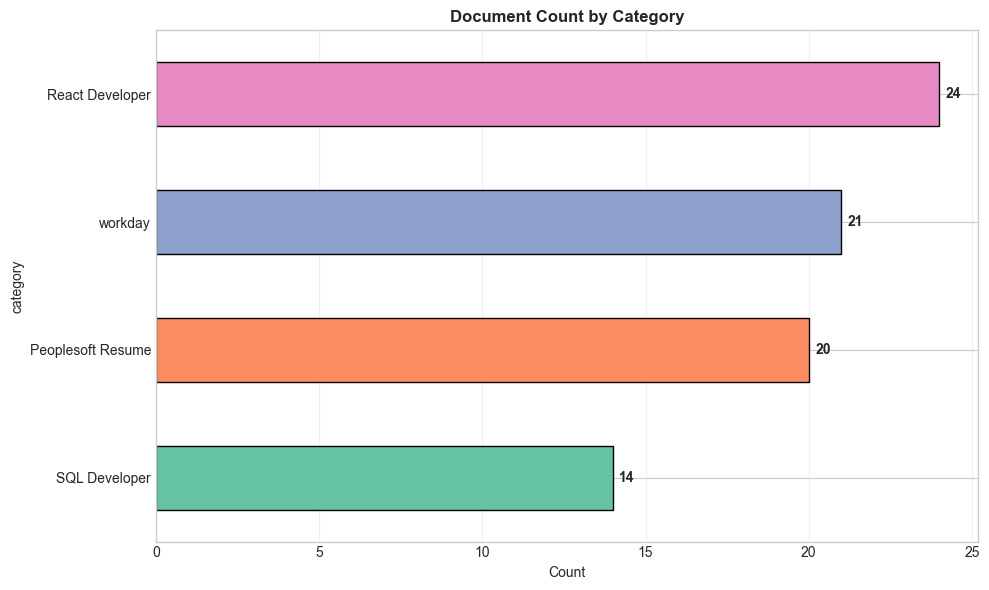

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

cat_counts = df_clean['category'].value_counts().sort_values(ascending=True)
colors = sns.color_palette("Set2", len(cat_counts))
cat_counts.plot(kind='barh', ax=ax, color=colors, edgecolor='black', linewidth=1)
ax.set_title('Document Count by Category', fontweight='bold', fontsize=12)
ax.set_xlabel('Count')
for i, v in enumerate(cat_counts):
    ax.text(v + 0.2, i, f'{int(v)}', va='center', fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Word & Character Metrics

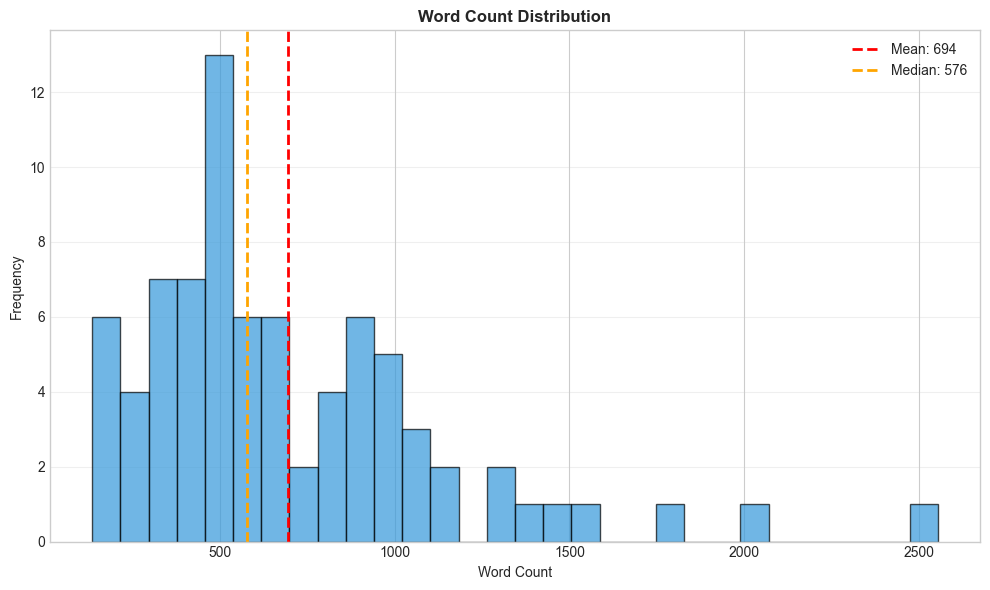

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_clean['word_count'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
mean_val = df_clean['word_count'].mean()
median_val = df_clean['word_count'].median()
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.0f}')
ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:.0f}')
ax.set_title('Word Count Distribution', fontweight='bold', fontsize=12)
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.legend(framealpha=0.95, edgecolor='black')
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

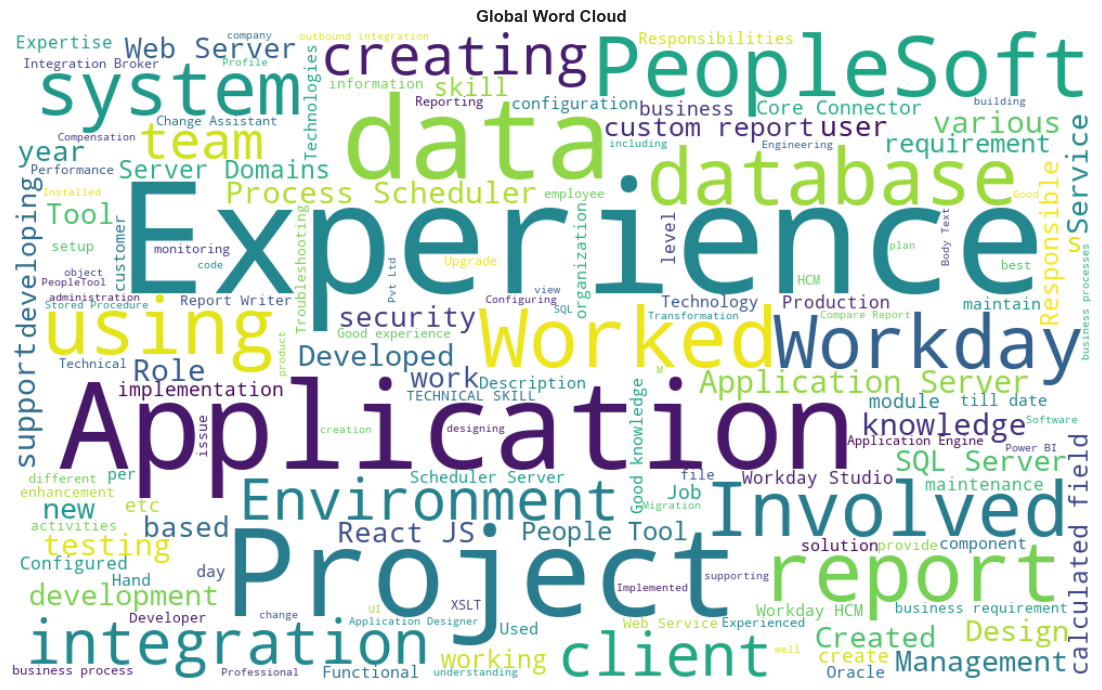

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))

all_text = ' '.join(df_clean['text'].tolist())
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='viridis', 
                     max_words=150, relative_scaling=0.5, min_font_size=10).generate(all_text)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Global Word Cloud', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()

Top 25 Most Frequent Words:
  1. and             2824 occurrences
  2. the             1393 occurrences
  3. for              671 occurrences
  4. experience       578 occurrences
  5. peoplesoft       440 occurrences
  6. with             424 occurrences
  7. application      396 occurrences
  8. using            381 occurrences
  9. workday          378 occurrences
  10. server           335 occurrences


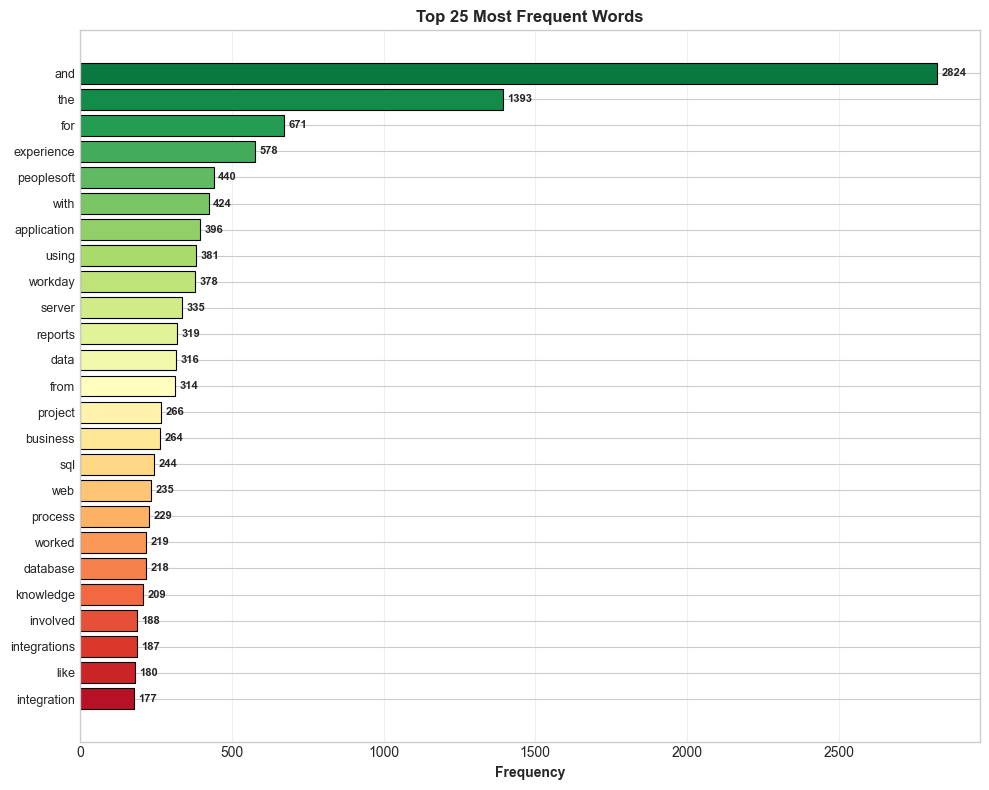

In [8]:
def get_top_words(texts, n=25):
    """Extract top N most frequent words from text corpus"""
    words = Counter()
    for text in texts:
        word_list = re.findall(r"\b[a-zA-Z]{3,}\b", text.lower())
        words.update(word_list)
    return words.most_common(n)

top_words_global = get_top_words(df_clean['text'], n=25)
top_words_df = pd.DataFrame(top_words_global, columns=['word', 'frequency'])

print("Top 25 Most Frequent Words:")
for i, (word, freq) in enumerate(top_words_global[:10], 1):
    print(f"  {i}. {word:15s} {freq:4d} occurrences")

fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette("RdYlGn_r", len(top_words_df))
ax.barh(range(len(top_words_df)), top_words_df['frequency'], color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(len(top_words_df)))
ax.set_yticklabels(top_words_df['word'], fontsize=9)
ax.set_xlabel('Frequency', fontweight='bold')
ax.set_title('Top 25 Most Frequent Words', fontweight='bold', fontsize=12)
ax.invert_yaxis()
for i, v in enumerate(top_words_df['frequency']):
    ax.text(v + 15, i, str(v), va='center', fontweight='bold', fontsize=8)
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Stop Words Analysis

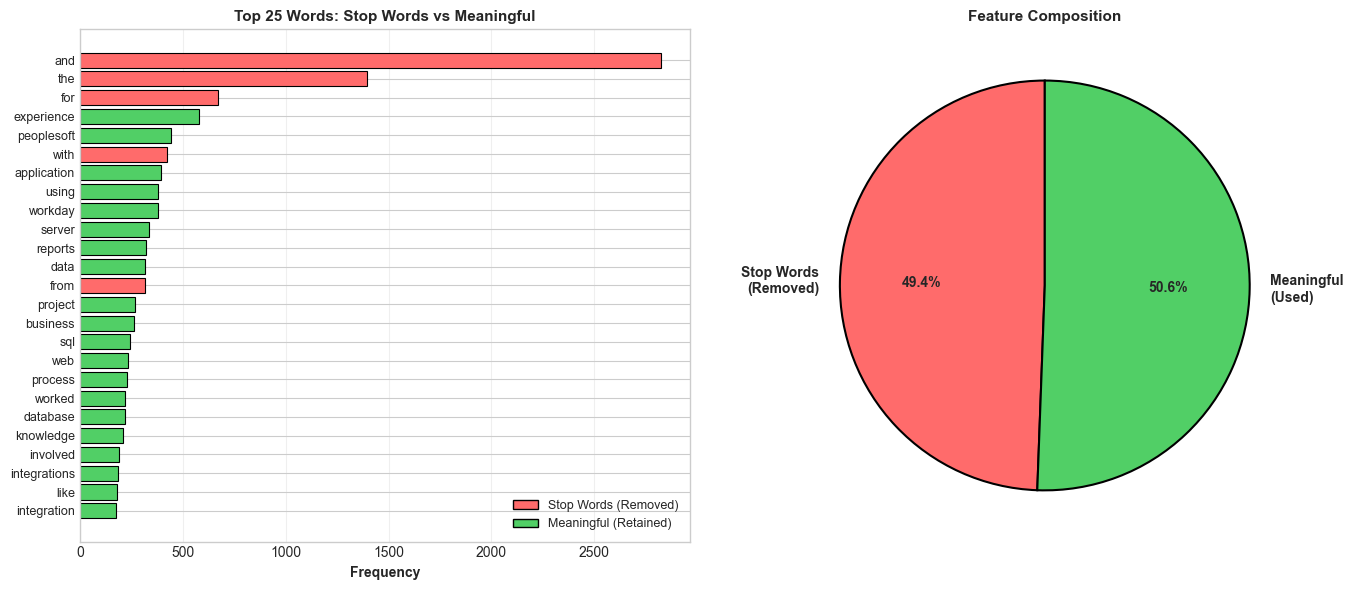

In [9]:
# Stop Words Impact Analysis 
# Visualize noise vs signal in vocabulary to validate cleaning effectiveness

stop_words_en = {'and', 'the', 'for', 'with', 'from', 'to', 'in', 'of', 'a', 'is', 'be'}

# Comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Frequency with stop words highlighted
ax1 = axes[0]
words_with = list(zip(*top_words_global))[0]
freqs_with = list(zip(*top_words_global))[1]
colors_with = ['#ff6b6b' if w in stop_words_en else '#51cf66' for w in words_with]

ax1.barh(range(len(words_with)), freqs_with, color=colors_with, edgecolor='black', linewidth=0.8)
ax1.set_yticks(range(len(words_with)))
ax1.set_yticklabels(words_with, fontsize=9)
ax1.set_xlabel('Frequency', fontweight='bold')
ax1.set_title('Top 25 Words: Stop Words vs Meaningful', fontweight='bold', fontsize=11)
ax1.invert_yaxis()
ax1.grid(alpha=0.3, axis='x')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#ff6b6b', edgecolor='black', label='Stop Words (Removed)'),
                   Patch(facecolor='#51cf66', edgecolor='black', label='Meaningful (Retained)')]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=9)

# Composition breakdown
ax2 = axes[1]
stop_word_count = sum(freq for word, freq in top_words_global if word in stop_words_en)
meaningful_word_count = sum(freq for word, freq in top_words_global if word not in stop_words_en)
percentages = [stop_word_count/(stop_word_count+meaningful_word_count)*100, 
               meaningful_word_count/(stop_word_count+meaningful_word_count)*100]

colors_impact = ['#ff6b6b', '#51cf66']
wedges, texts, autotexts = ax2.pie(percentages, labels=['Stop Words\n(Removed)', 'Meaningful\n(Used)'], 
                                     autopct='%1.1f%%', colors=colors_impact, startangle=90,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'},
                                     wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax2.set_title('Feature Composition', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

## Apply Stopwords Removal

Remove English stopwords and create cleaned text for analysis

In [10]:
# Import NLTK stopwords corpus
from nltk.corpus import stopwords
import nltk

# Download English stopwords corpus
nltk.download('stopwords', quiet=True)

# Load the set of English stopwords for efficient lookup
stop_words_set = set(stopwords.words('english'))

# Create cleaned text by filtering out stopwords and words shorter than 2 characters
df_clean['text_no_stopwords'] = df_clean['text'].apply(
    lambda text: ' '.join([word for word in text.lower().split() 
                          if word not in stop_words_set and len(word) > 1])
    if text else ""
)

# Calculate stopwords removal statistics for analysis
df_clean['word_count_original'] = df_clean['word_count']
df_clean['word_count_after_removal'] = df_clean['text_no_stopwords'].apply(lambda x: len(x.split()) if x else 0)
df_clean['stopwords_removed_count'] = df_clean['word_count_original'] - df_clean['word_count_after_removal']
df_clean['stopwords_removal_pct'] = (df_clean['stopwords_removed_count'] / df_clean['word_count_original'] * 100).round(2)

print("\n" + "─" * 70)
print("STOPWORDS REMOVAL IMPACT ANALYSIS")
print("─" * 70)
print(f"\nCorpus-Level Statistics:")
print(f"  • Total stopwords removed:     {df_clean['stopwords_removed_count'].sum():,}")
print(f"  • Average per document:        {df_clean['stopwords_removed_count'].mean():.1f} words")
print(f"  • Average removal rate:        {df_clean['stopwords_removal_pct'].mean():.1f}%")

print(f"\nCategory Breakdown:")
print(f"{'Category':<25} {'Before (avg)':<15} {'After (avg)':<15} {'Removed (%)':<15}")
print(f"{'-'*70}")
for category in sorted(df_clean['category'].unique()):
    cat_data = df_clean[df_clean['category'] == category]
    avg_before = cat_data['word_count_original'].mean()
    avg_after = cat_data['word_count_after_removal'].mean()
    avg_pct = cat_data['stopwords_removal_pct'].mean()
    print(f"{category:<25} {avg_before:<15.0f} {avg_after:<15.0f} {avg_pct:<15.1f}%")



──────────────────────────────────────────────────────────────────────
STOPWORDS REMOVAL IMPACT ANALYSIS
──────────────────────────────────────────────────────────────────────

Corpus-Level Statistics:
  • Total stopwords removed:     14,433
  • Average per document:        182.7 words
  • Average removal rate:        26.8%

Category Breakdown:
Category                  Before (avg)    After (avg)     Removed (%)    
----------------------------------------------------------------------
Peoplesoft Resume         951             711             25.7           %
React Developer           391             279             28.4           %
SQL Developer             595             433             27.2           %
workday                   862             640             25.7           %


## Category-Specific Word Clouds

Visualize word frequency patterns for each job category

Category-Specific Word Clouds:



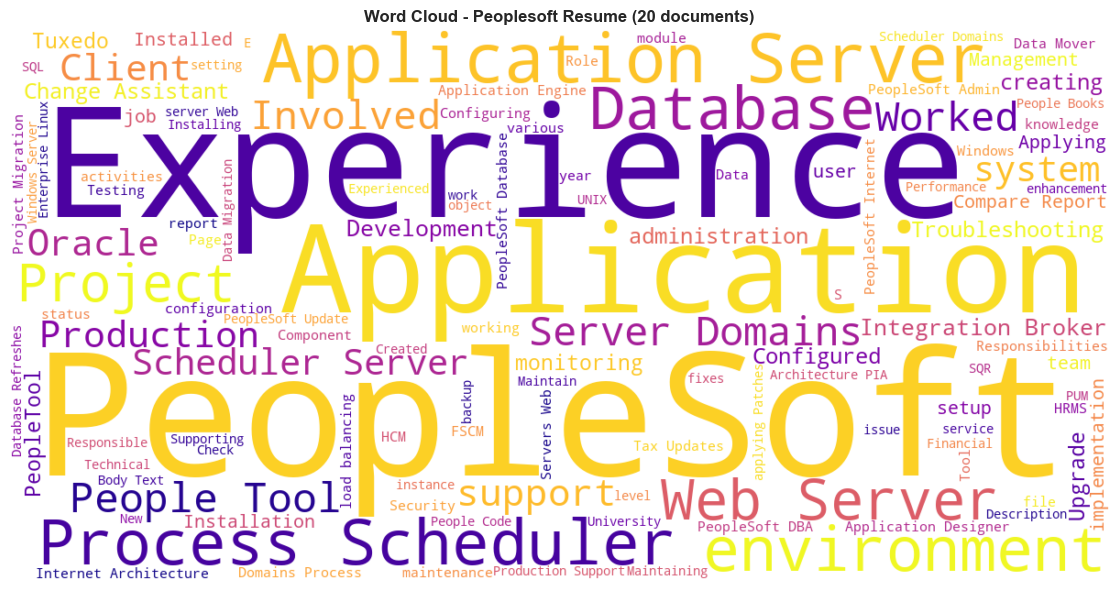

  Peoplesoft Resume


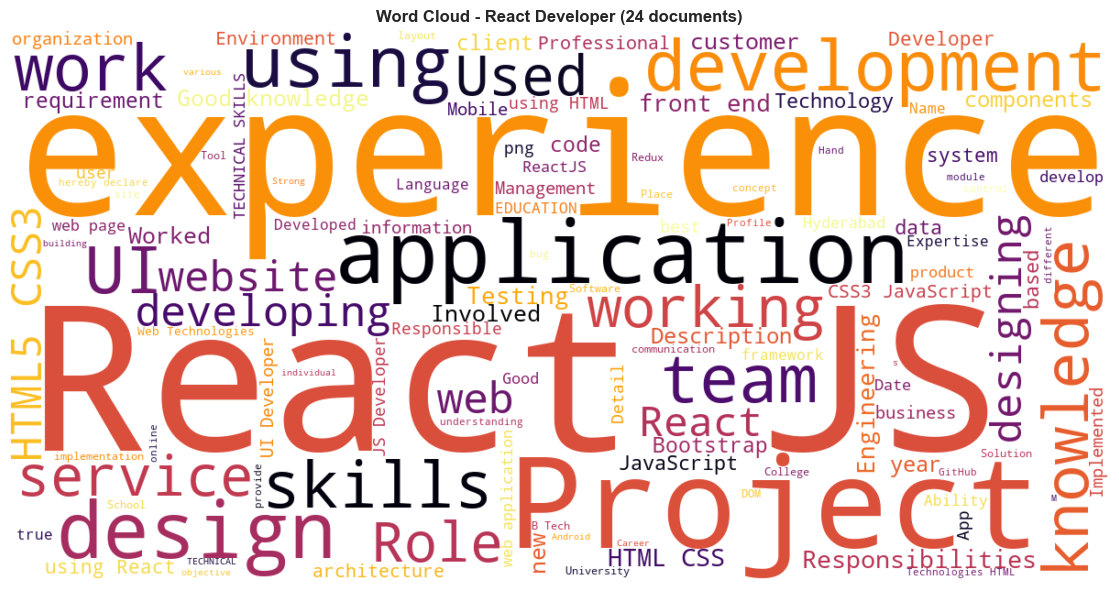

  React Developer


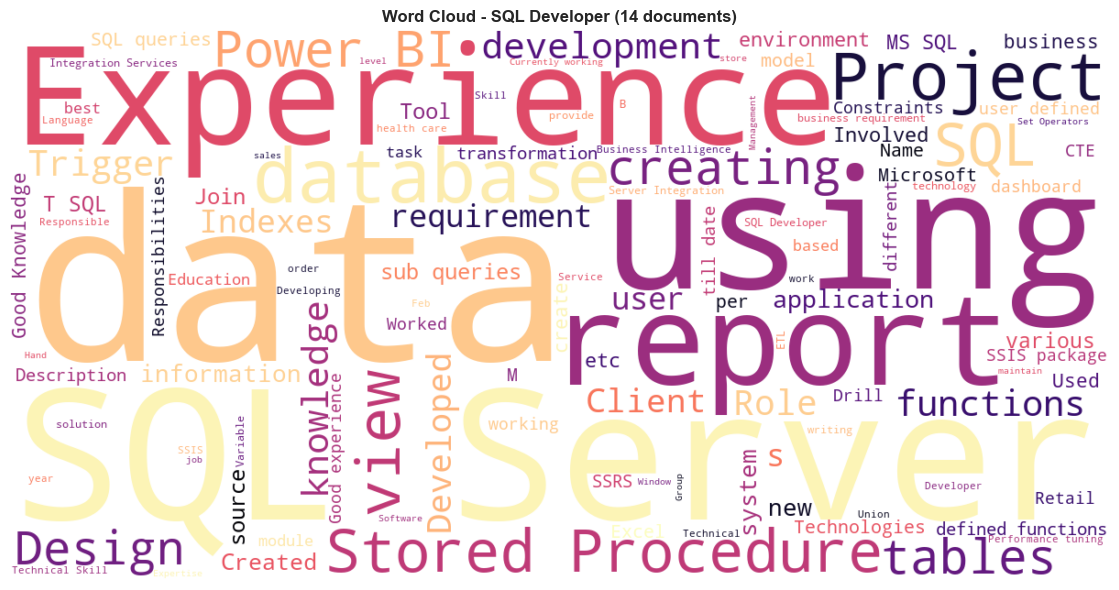

  SQL Developer


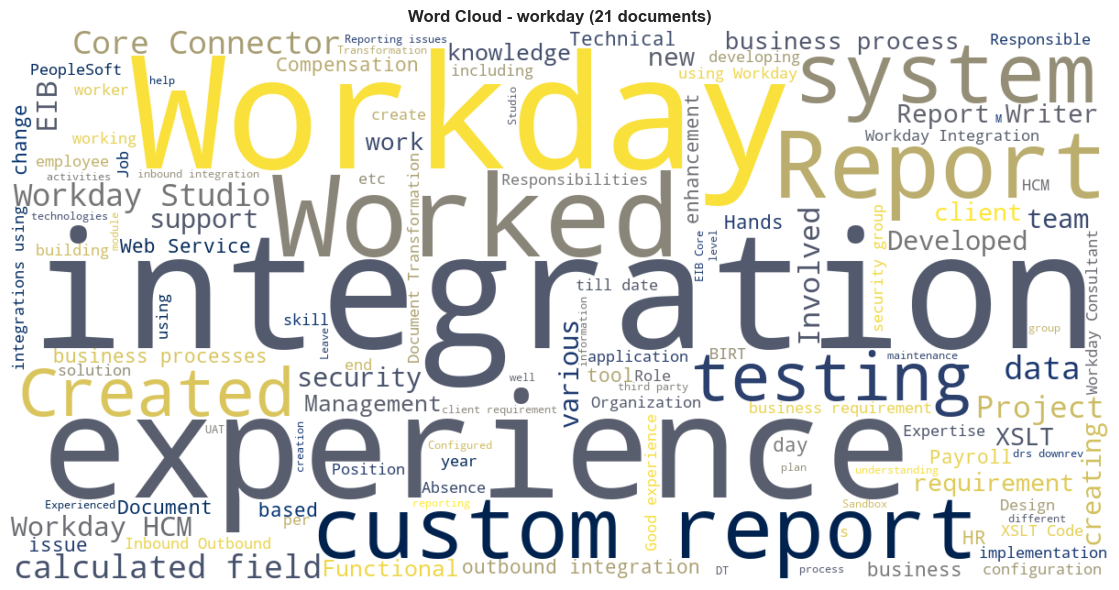

  workday


In [11]:
print("Category-Specific Word Clouds:\n")

colormaps = ['plasma', 'inferno', 'magma', 'cividis', 'twilight']
categories_sorted = sorted(df_clean['category'].unique())

for idx, category in enumerate(categories_sorted):
    cat_text = ' '.join(df_clean[df_clean['category'] == category]['text'].tolist())
    if cat_text.strip():
        fig, ax = plt.subplots(figsize=(14, 6))
        doc_count = len(df_clean[df_clean['category'] == category])
        wc = WordCloud(width=1200, height=600, background_color='white', 
                      colormap=colormaps[idx % len(colormaps)], max_words=120,
                      relative_scaling=0.5, min_font_size=10).generate(cat_text)
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Word Cloud - {category} ({doc_count} documents)', fontweight='bold', fontsize=12)
        plt.tight_layout()
        plt.show()
        print(f"  {category}")

## TF-IDF Keywords Analysis

Identify important keywords using TF-IDF scoring

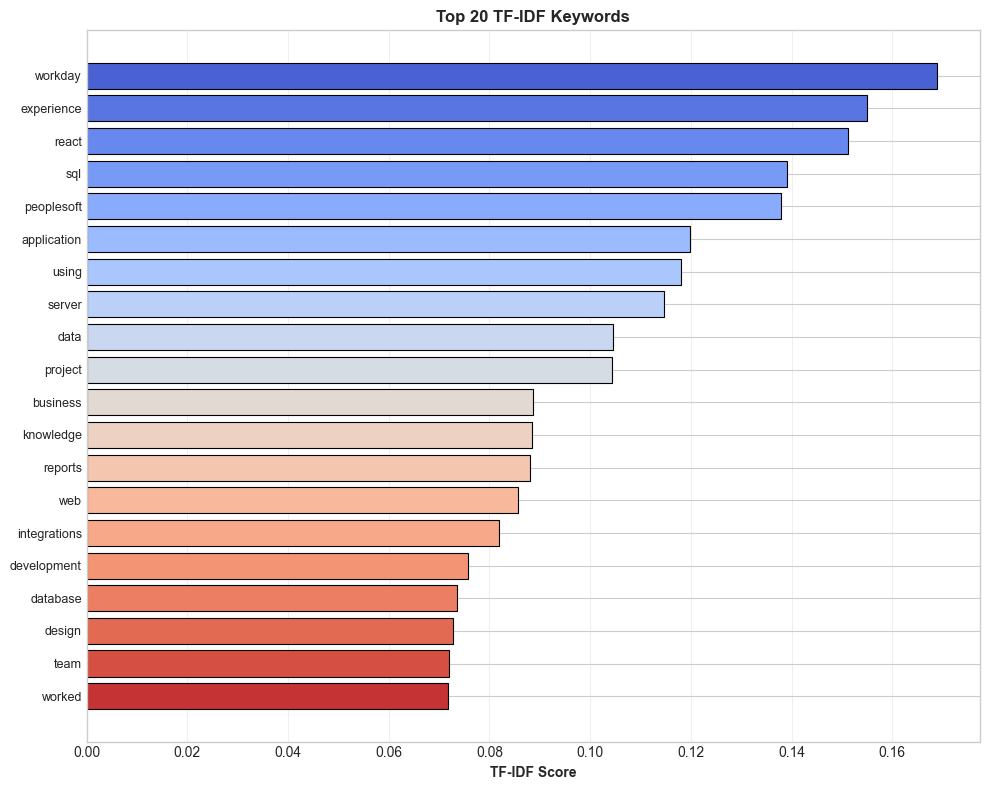

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF analysis
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=50, min_df=2)
tfidf_matrix = tfidf_vec.fit_transform(df_clean['text'])
tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()
tfidf_df = pd.DataFrame({'keyword': tfidf_vec.get_feature_names_out(), 'score': tfidf_scores}).sort_values('score', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
top_tfidf = tfidf_df.head(20)
colors = sns.color_palette("coolwarm", len(top_tfidf))
ax.barh(range(len(top_tfidf)), top_tfidf['score'].values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(len(top_tfidf)))
ax.set_yticklabels(top_tfidf['keyword'].values, fontsize=9)
ax.set_xlabel('TF-IDF Score', fontweight='bold')
ax.set_title('Top 20 TF-IDF Keywords', fontweight='bold', fontsize=12)
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Technical Skills Detection

Identified presence and frequency of 15 pre-defined technical skills in resumes

Technical Skills Detected:
  sql             31 mentions ( 39.2%)
  peoplesoft      30 mentions ( 38.0%)
  react           21 mentions ( 26.6%)
  workday         21 mentions ( 26.6%)
  javascript      19 mentions ( 24.1%)
  excel           17 mentions ( 21.5%)
  java            13 mentions ( 16.5%)
  aws              7 mentions (  8.9%)
  python           3 mentions (  3.8%)
  azure            1 mentions (  1.3%)


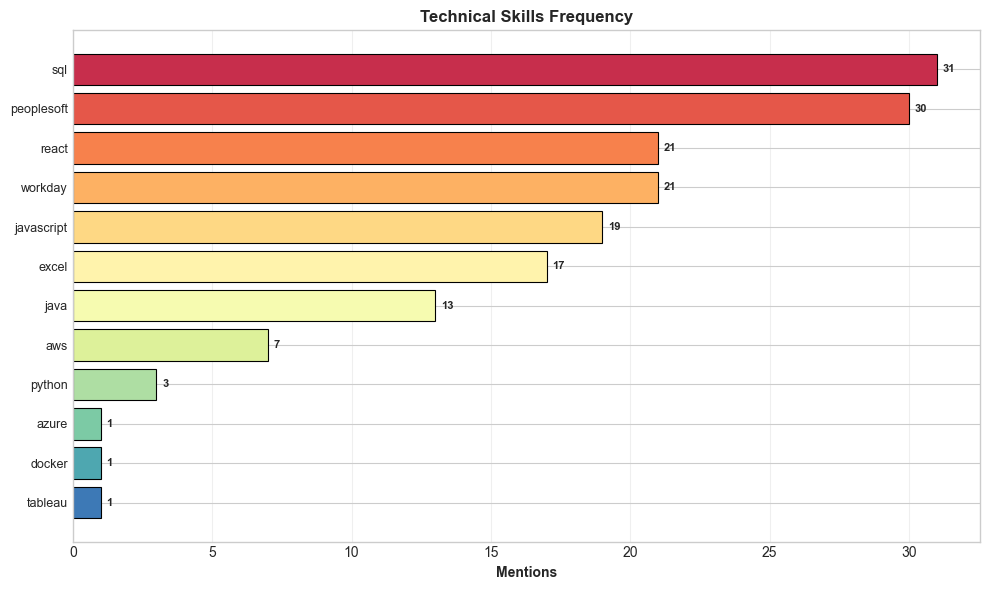

In [13]:
# Skills detection
SKILLS = ['python', 'sql', 'java', 'javascript', 'react', 'aws', 'azure', 
          'excel', 'tableau', 'powerbi', 'docker', 'kubernetes', 'peoplesoft', 'workday', 'sap']

skill_counts = {skill: df_clean['text'].str.lower().str.contains(fr'\b{skill}\b', na=False).sum() 
                for skill in SKILLS if df_clean['text'].str.lower().str.contains(fr'\b{skill}\b', na=False).sum() > 0}
skill_df = pd.DataFrame(list(skill_counts.items()), columns=['skill', 'count']).sort_values('count', ascending=False)

print("Technical Skills Detected:")
for idx, row in skill_df.head(10).iterrows():
    pct = 100 * row['count'] / len(df_clean)
    print(f"  {row['skill']:15s} {row['count']:2d} mentions ({pct:5.1f}%)")

fig, ax = plt.subplots(figsize=(10, 6))
if len(skill_df) > 0:
    colors = sns.color_palette("Spectral", len(skill_df))
    ax.barh(range(len(skill_df)), skill_df['count'].values, color=colors, edgecolor='black', linewidth=0.8)
    ax.set_yticks(range(len(skill_df)))
    ax.set_yticklabels(skill_df['skill'].values, fontsize=9)
    ax.set_xlabel('Mentions', fontweight='bold')
    ax.set_title('Technical Skills Frequency', fontweight='bold', fontsize=12)
    ax.invert_yaxis()
    for i, v in enumerate(skill_df['count'].values):
        ax.text(v + 0.2, i, str(v), va='center', fontweight='bold', fontsize=8)
    ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Bigrams Extraction

Bigram text extraction and feature analysis

Top Bigrams (2-word phrases):
  process scheduler              107
  sql server                     104
  application server             91
  react js                       88
  people tools                   73


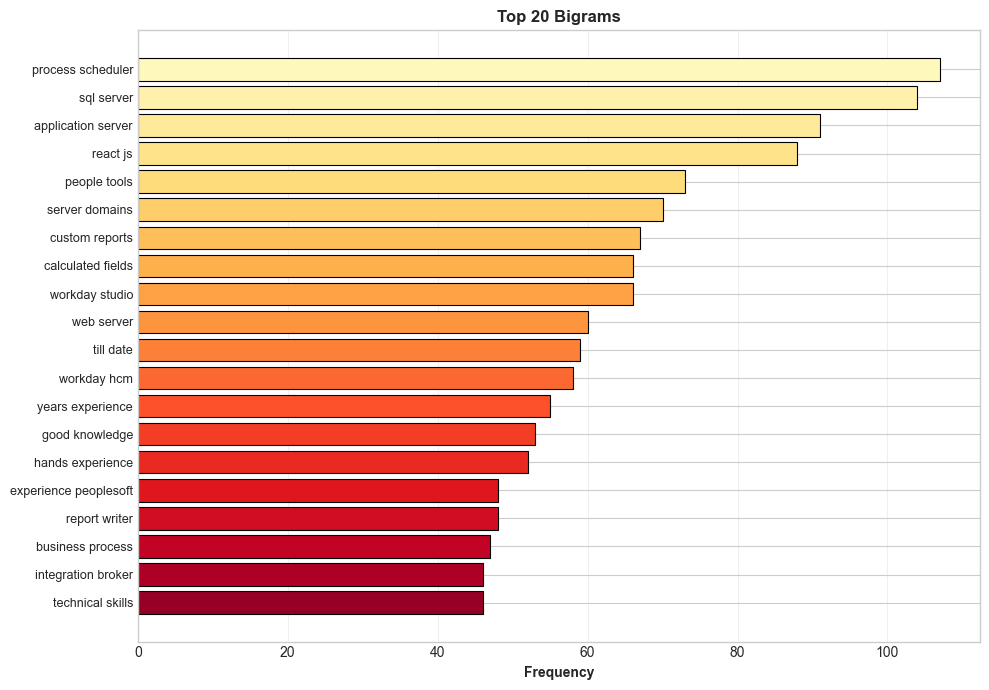

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Bigrams
bigram_vec = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=30, min_df=2)
bigram_matrix = bigram_vec.fit_transform(df_clean['text'])
bigram_counts = np.array(bigram_matrix.sum(axis=0)).ravel()
bigram_df = pd.DataFrame({'bigram': bigram_vec.get_feature_names_out(), 'count': bigram_counts}).sort_values('count', ascending=False).head(20)

print("Top Bigrams (2-word phrases):")
for idx, row in bigram_df.head(5).iterrows():
    print(f"  {row['bigram']:30s} {row['count']:2d}")

fig, ax = plt.subplots(figsize=(10, 7))
colors = sns.color_palette("YlOrRd", len(bigram_df))
ax.barh(range(len(bigram_df)), bigram_df['count'].values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(len(bigram_df)))
ax.set_yticklabels(bigram_df['bigram'].values, fontsize=9)
ax.set_xlabel('Frequency', fontweight='bold')
ax.set_title('Top 20 Bigrams', fontweight='bold', fontsize=12)
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Advanced NLP Features: N-Grams & Phrase Analysis

Bigram and trigram extraction and frequency analysis

Top Trigrams (3-word phrases):
  process scheduler servers                36
  servers web servers                      26
  peoplesoft internet architecture         25
  true best knowledge                      22
  inbound outbound integrations            21


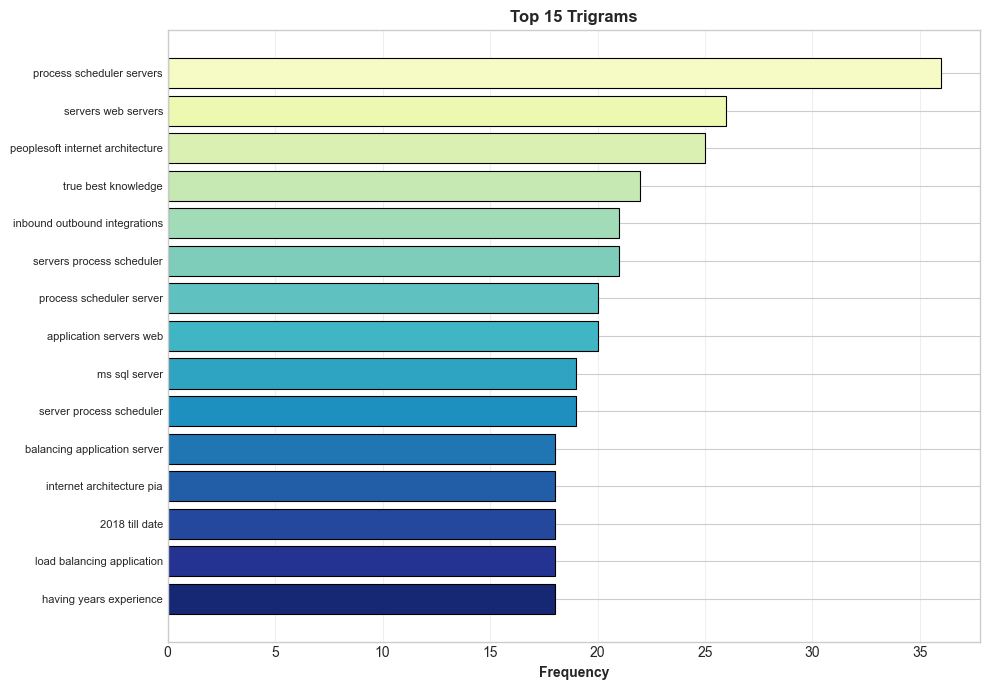

In [15]:
# Trigrams with aggressive garbage filtering
trigram_vec = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=30, min_df=2)
trigram_matrix = trigram_vec.fit_transform(df_clean['text'])
trigram_counts = np.array(trigram_matrix.sum(axis=0)).ravel()
trigram_df = pd.DataFrame({'trigram': trigram_vec.get_feature_names_out(), 'count': trigram_counts}).sort_values('count', ascending=False)

# Remove trigrams containing known garbage/metadata patterns
garbage_patterns = [
    'dk\d+', 'li\d+', 'tx\d+', 'lx\d+',  # XML namespace codes
    'clmap', 'drawingml', 'hlink', 'blink', 'fol',  # DrawingML artifacts
    'new roman', 'arial', 'calibri', 'courier', 'georgia', 'verdana',  # Fonts
    '2006', 'main'  # Version/container elements
]
# Also explicitly exclude problematic trigrams
blocked_trigrams = ['times new roman']

mask_pattern = trigram_df['trigram'].str.contains('|'.join(garbage_patterns), regex=True, case=False)
mask_exact = trigram_df['trigram'].isin(blocked_trigrams)
trigram_df = trigram_df[~(mask_pattern | mask_exact)].head(15)

print("Top Trigrams (3-word phrases):")
for idx, row in trigram_df.head(5).iterrows():
    print(f"  {row['trigram']:40s} {row['count']:2d}")

fig, ax = plt.subplots(figsize=(10, 7))
colors = sns.color_palette("YlGnBu", len(trigram_df))
ax.barh(range(len(trigram_df)), trigram_df['count'].values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(len(trigram_df)))
ax.set_yticklabels(trigram_df['trigram'].values, fontsize=8)
ax.set_xlabel('Frequency', fontweight='bold')
ax.set_title('Top 15 Trigrams', fontweight='bold', fontsize=12)
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Text Complexity Metrics

Readability and linguistic complexity analysis

Computing text metrics...


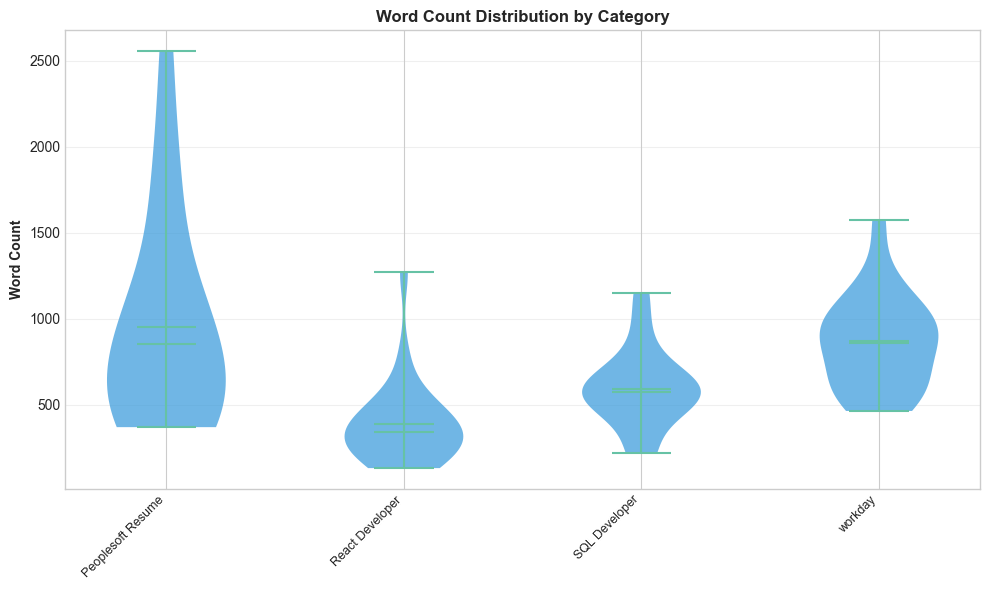

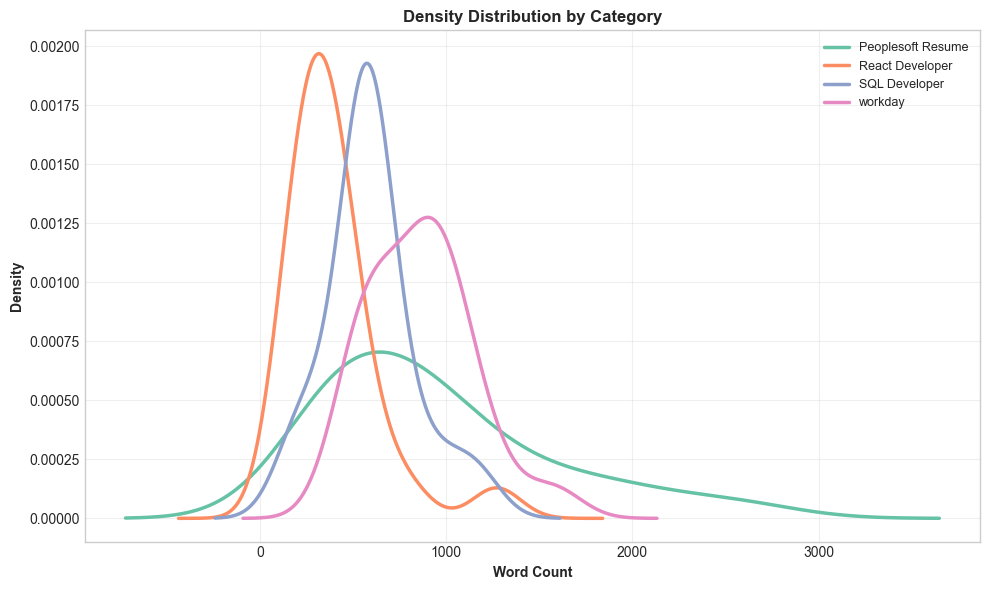

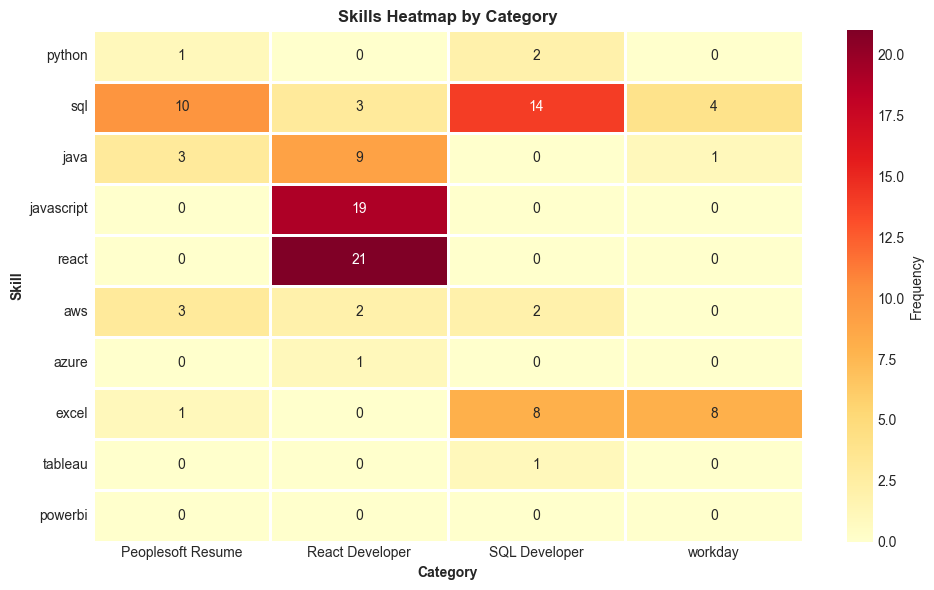

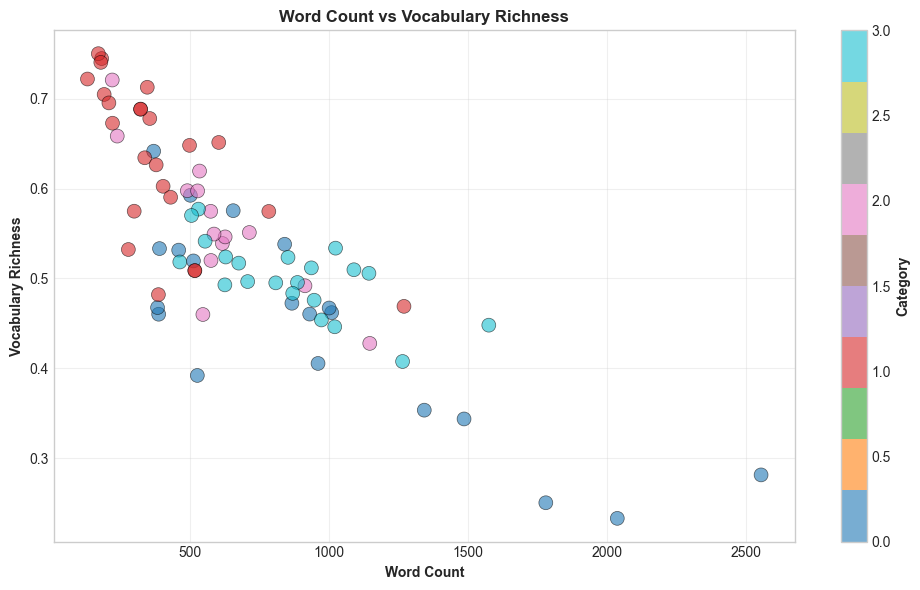

In [16]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt', quiet=True)

print("Computing text metrics...")

df_clean['sentences'] = df_clean['text'].apply(lambda x: len(sent_tokenize(x)))
df_clean['avg_word_length'] = df_clean['text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)
df_clean['unique_words'] = df_clean['text'].apply(lambda x: len(set(x.lower().split())))
df_clean['vocab_richness'] = df_clean['unique_words'] / df_clean['word_count']

categories_list = sorted(df_clean['category'].unique())

# Violin plot
fig, ax = plt.subplots(figsize=(10, 6))
data_violin = [df_clean[df_clean['category'] == cat]['word_count'].values for cat in categories_list]
parts = ax.violinplot(data_violin, positions=range(len(categories_list)), showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('#3498db')
    pc.set_alpha(0.7)
ax.set_xticks(range(len(categories_list)))
ax.set_xticklabels(categories_list, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Word Count', fontweight='bold')
ax.set_title('Word Count Distribution by Category', fontweight='bold', fontsize=12)
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# KDE plot
fig, ax = plt.subplots(figsize=(10, 6))
colors_kde = sns.color_palette("Set2", len(categories_list))
for idx, category in enumerate(categories_list):
    data = df_clean[df_clean['category'] == category]['word_count']
    data.plot.kde(ax=ax, label=category, linewidth=2.5, color=colors_kde[idx])
ax.set_xlabel('Word Count', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.set_title('Density Distribution by Category', fontweight='bold', fontsize=12)
ax.legend(framealpha=0.95, edgecolor='black', fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Skills heatmap
fig, ax = plt.subplots(figsize=(10, 6))
skill_matrix = pd.DataFrame()
for category in categories_list:
    cat_data = df_clean[df_clean['category'] == category]['text'].str.lower()
    skill_counts_cat = {skill: cat_data.str.contains(fr'\b{skill}\b', na=False).sum() 
                       for skill in SKILLS[:10]}
    skill_matrix[category] = skill_counts_cat
sns.heatmap(skill_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax, 
           cbar_kws={'label': 'Frequency'}, linewidths=1, linecolor='white')
ax.set_title('Skills Heatmap by Category', fontweight='bold', fontsize=12)
ax.set_xlabel('Category', fontweight='bold')
ax.set_ylabel('Skill', fontweight='bold')
plt.tight_layout()
plt.show()

# Scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
category_colors = {cat: i for i, cat in enumerate(categories_list)}
colors_scatter = [category_colors[cat] for cat in df_clean['category']]
scatter = ax.scatter(df_clean['word_count'], df_clean['vocab_richness'], 
                    c=colors_scatter, cmap='tab10', s=100, alpha=0.6, 
                    edgecolors='black', linewidth=0.5)
ax.set_xlabel('Word Count', fontweight='bold')
ax.set_ylabel('Vocabulary Richness', fontweight='bold')
ax.set_title('Word Count vs Vocabulary Richness', fontweight='bold', fontsize=12)
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Category', fontweight='bold')
plt.tight_layout()
plt.show()

## Summary & Export

Exploratory data analysis summary and CSV artifact export

In [17]:
print("\n" + "═" * 80)
print("EXPLORATORY DATA ANALYSIS - FINAL SUMMARY")
print("═" * 80)

print(f"\nDataset Overview:")
print(f"  • Total resumes analyzed:     {len(df_clean)}")
print(f"  • Number of categories:       {len(categories_list)}")
print(f"  • Total words in corpus:      {df_clean['word_count'].sum():,}")
print(f"  • Average words per document: {df_clean['word_count'].mean():.0f}")
print(f"  • Corpus size:                {df_clean['char_count'].sum():,} characters")

print(f"\nCategory Breakdown:")
for cat in categories_list:
    count = len(df_clean[df_clean['category'] == cat])
    pct = 100 * count / len(df_clean)
    avg_words = df_clean[df_clean['category'] == cat]['word_count'].mean()
    print(f"  • {cat:23s} {count:2d} resumes ({pct:5.1f}%) | Avg: {avg_words:4.0f} words")

print(f"\nTop 10 Most Frequent Words (Original Text):")
for i, (word, freq) in enumerate(top_words_global[:10], 1):
    print(f"  {i:2d}. {word:20s} — {freq:4d} occurrences")

print(f"\nTop Technical Skills Detected:")
for idx, row in skill_df.head(8).iterrows():
    pct = 100 * row['count'] / len(df_clean)
    print(f"  • {row['skill']:15s} {row['count']:2d} mentions ({pct:5.1f}%)")

print(f"\nN-Gram Analysis:")
print(f"  • Most common bigram:  '{bigram_df.iloc[0]['bigram']}' ({bigram_df.iloc[0]['count']} occurrences)")
print(f"  • Most common trigram: '{trigram_df.iloc[0]['trigram']}' ({trigram_df.iloc[0]['count']} occurrences)")

print(f"\nText Complexity Metrics:")
print(f"  • Average sentence count:      {df_clean['sentences'].mean():.1f} sentences/doc")
print(f"  • Average word length:         {df_clean['avg_word_length'].mean():.2f} characters")
print(f"  • Average vocabulary richness: {df_clean['vocab_richness'].mean():.1%}")

print(f"\n" + "═" * 80)

# Export processed data artifacts to CSV format for downstream analysis and model training
print("\nExporting Processed Data Artifacts")
print("─" * 40)

# Create output directory for processed datasets (portable across different drives)
output_dir = Path.cwd() / "processed_data"
output_dir.mkdir(parents=True, exist_ok=True)

saved_files = []
failed_saves = []

# Export: Complete resume data with all metadata and text
try:
    df.to_csv(output_dir / "extracted_resumes_full.csv", index=False)
    saved_files.append("extracted_resumes_full.csv")
    print(f"  ✓ extracted_resumes_full.csv ({len(df)} rows)")
except Exception as e:
    failed_saves.append(('extracted_resumes_full.csv', str(e)))
    print(f"  ✗ extracted_resumes_full.csv")

# Export: Resume metadata only (without full text)
try:
    df_meta = df.drop(columns=['text'])
    df_meta.to_csv(output_dir / "extracted_resumes_metadata.csv", index=False)
    saved_files.append("extracted_resumes_metadata.csv")
    print(f"  ✓ extracted_resumes_metadata.csv ({len(df_meta)} rows)")
except Exception as e:
    failed_saves.append(('extracted_resumes_metadata.csv', str(e)))
    print(f"  ✗ extracted_resumes_metadata.csv")

# Export: Cleaned resume data with stopwords removed and additional features
try:
    df_clean.to_csv(output_dir / "resumes_cleaned.csv", index=False)
    saved_files.append("resumes_cleaned.csv")
    print(f"  ✓ resumes_cleaned.csv ({len(df_clean)} rows)")
except Exception as e:
    failed_saves.append(('resumes_cleaned.csv', str(e)))
    print(f"  ✗ resumes_cleaned.csv")

# Export: Global word frequency analysis
try:
    top_words_df.to_csv(output_dir / "top_words_global.csv", index=False)
    saved_files.append("top_words_global.csv")
    print(f"  ✓ top_words_global.csv ({len(top_words_df)} rows)")
except Exception as e:
    failed_saves.append(('top_words_global.csv', str(e)))
    print(f"  ✗ top_words_global.csv")

# Export: TF-IDF weighted important keywords
try:
    tfidf_df.to_csv(output_dir / "tfidf_keywords.csv", index=False)
    saved_files.append("tfidf_keywords.csv")
    print(f"  ✓ tfidf_keywords.csv ({len(tfidf_df)} rows)")
except Exception as e:
    failed_saves.append(('tfidf_keywords.csv', str(e)))
    print(f"  ✗ tfidf_keywords.csv")

# Export: Technical skills frequency across dataset
try:
    skill_df.to_csv(output_dir / "skills_frequency.csv", index=False)
    saved_files.append("skills_frequency.csv")
    print(f"  ✓ skills_frequency.csv ({len(skill_df)} rows)")
except Exception as e:
    failed_saves.append(('skills_frequency.csv', str(e)))
    print(f"  ✗ skills_frequency.csv")

# Export: N-gram frequency analysis (bigrams and trigrams)
try:
    bigram_df.to_csv(output_dir / "bigrams.csv", index=False)
    trigram_df.to_csv(output_dir / "trigrams.csv", index=False)
    saved_files.append("bigrams.csv")
    saved_files.append("trigrams.csv")
    print(f"  ✓ bigrams.csv ({len(bigram_df)} rows)")
    print(f"  ✓ trigrams.csv ({len(trigram_df)} rows)")
except Exception as e:
    failed_saves.append(('n-grams', str(e)))
    print(f"  ✗ n-grams export failed")

print(f"\n" + "─" * 40)
print(f"Export Summary:")
print(f"  Location: {output_dir}")
print(f"  Files saved: {len(saved_files)}/{len(saved_files) + len(failed_saves)}")

if failed_saves:
    print(f"  Failed: {len(failed_saves)}")

print(f"\n" + "═" * 80)
print("EDA PIPELINE COMPLETE")
print("═" * 80)
print(f"\nProcessing Summary:")
print(f"  • Resumes analyzed:       {len(df_clean)}")
print(f"  • Categories identified:  {len(categories_list)}")
print(f"  • Datasets exported:      {len(saved_files)} files")
print(f"\n→ Datasets ready for classification model training")



════════════════════════════════════════════════════════════════════════════════
EXPLORATORY DATA ANALYSIS - FINAL SUMMARY
════════════════════════════════════════════════════════════════════════════════

Dataset Overview:
  • Total resumes analyzed:     79
  • Number of categories:       4
  • Total words in corpus:      54,838
  • Average words per document: 694
  • Corpus size:                396,769 characters

Category Breakdown:
  • Peoplesoft Resume       20 resumes ( 25.3%) | Avg:  951 words
  • React Developer         24 resumes ( 30.4%) | Avg:  391 words
  • SQL Developer           14 resumes ( 17.7%) | Avg:  595 words
  • workday                 21 resumes ( 26.6%) | Avg:  862 words

Top 10 Most Frequent Words (Original Text):
   1. and                  — 2824 occurrences
   2. the                  — 1393 occurrences
   3. for                  —  671 occurrences
   4. experience           —  578 occurrences
   5. peoplesoft           —  440 occurrences
   6. with           

# Model Building & Evaluation

## Multi-Class Resume Classification using Machine Learning

**Objective:** Build and compare multiple classification models to accurately categorize resumes into their respective job categories.

**Approach:**
1. **Data Loading & Encoding** - Load preprocessed data and encode categorical labels
2. **Text Vectorization** - Transform text into TF-IDF features
3. **Train-Test Split** - Split data with stratification to preserve class balance
4. **Model Training** - Train multiple classifiers with cross-validation
5. **Model Evaluation** - Compare models using multiple metrics
6. **Model Selection** - Select the best performing model based on comprehensive evaluation
7. **Model Persistence** - Save the final model and preprocessing artifacts for deployment

## Step 1: Data Loading & Label Encoding

Load the cleaned resume data and encode categorical labels into numeric format for machine learning models.

STEP 1: DATA LOADING & LABEL ENCODING

✓ Dataset loaded successfully
  • Total samples: 79
  • Number of categories: 4

  Category Mapping:
    0 → Peoplesoft Resume       (20 samples, 25.3%)
    1 → React Developer         (24 samples, 30.4%)
    2 → SQL Developer           (14 samples, 17.7%)
    3 → workday                 (21 samples, 26.6%)


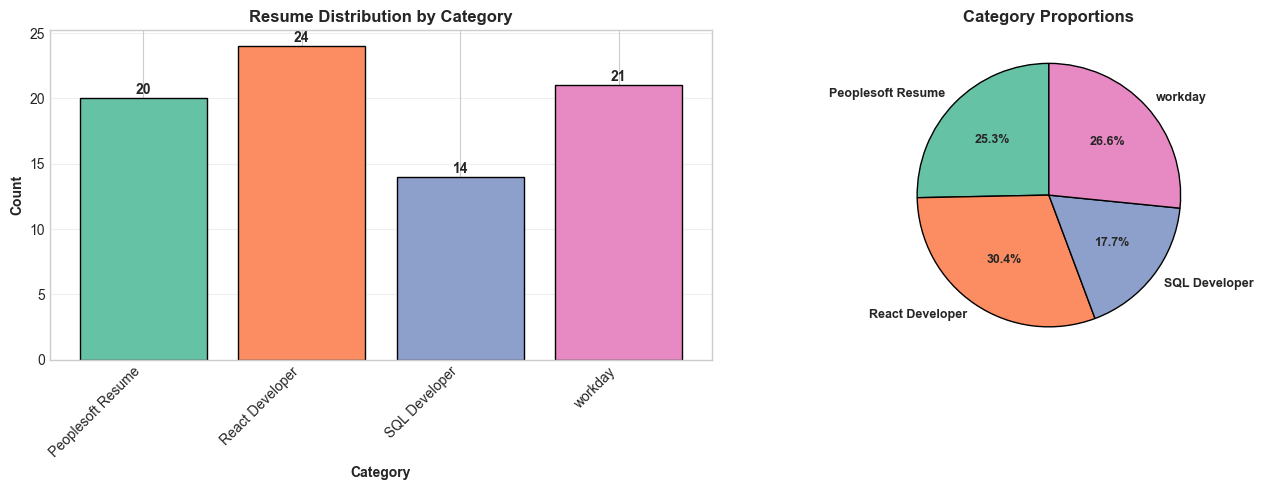


✓ Labels encoded: [0 1 2 3]


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from CSV
df_model = pd.read_csv('processed_data/resumes_cleaned.csv')
y = df_model['category'].values
X_text = df_model['text_no_stopwords'].values

# Encode categories to numeric labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("=" * 70)
print("STEP 1: DATA LOADING & LABEL ENCODING")
print("=" * 70)
print(f"\n✓ Dataset loaded successfully")
print(f"  • Total samples: {len(X_text)}")
print(f"  • Number of categories: {len(le.classes_)}")
print(f"\n  Category Mapping:")
for idx, cat in enumerate(le.classes_):
    count = np.sum(y_encoded == idx)
    pct = 100 * count / len(y_encoded)
    print(f"    {idx} → {cat:23s} ({count} samples, {pct:.1f}%)")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = sns.color_palette("Set2", len(le.classes_))
cat_counts = pd.Series(y).value_counts().sort_index()
axes[0].bar(range(len(cat_counts)), cat_counts.values, color=colors, edgecolor='black', linewidth=1)
axes[0].set_xticks(range(len(cat_counts)))
axes[0].set_xticklabels(le.classes_, rotation=45, ha='right')
axes[0].set_xlabel('Category', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].set_title('Resume Distribution by Category', fontweight='bold', fontsize=12)
for i, v in enumerate(cat_counts.values):
    axes[0].text(i, v + 0.3, str(v), ha='center', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
wedges, texts, autotexts = axes[1].pie(cat_counts.values, labels=le.classes_, 
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        textprops={'fontsize': 9, 'fontweight': 'bold'},
                                        wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[1].set_title('Category Proportions', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n✓ Labels encoded: {np.unique(y_encoded)}")

## Step 2: Text Vectorization for Model Training

Transform cleaned text into numerical features using TF-IDF vectorization optimized for classification.

> **Note:** This is different from the EDA TF-IDF analysis which used only 50 features for keyword visualization. Here we use 1000 features with bigrams for optimal model performance.

**TF-IDF Parameters for Classification:**
- `max_features=1000` - Larger vocabulary for better discrimination
- `ngram_range=(1,2)` - Capture both single words and phrases
- `min_df=2, max_df=0.8` - Filter rare/common terms
- `sublinear_tf=True` - Logarithmic scaling for better feature weighting

STEP 2: TF-IDF VECTORIZATION

✓ Text successfully transformed to numerical features
  • TF-IDF matrix shape: (79, 1000)
  • Number of documents: 79
  • Features extracted: 1000
  • Matrix density: 20.15%


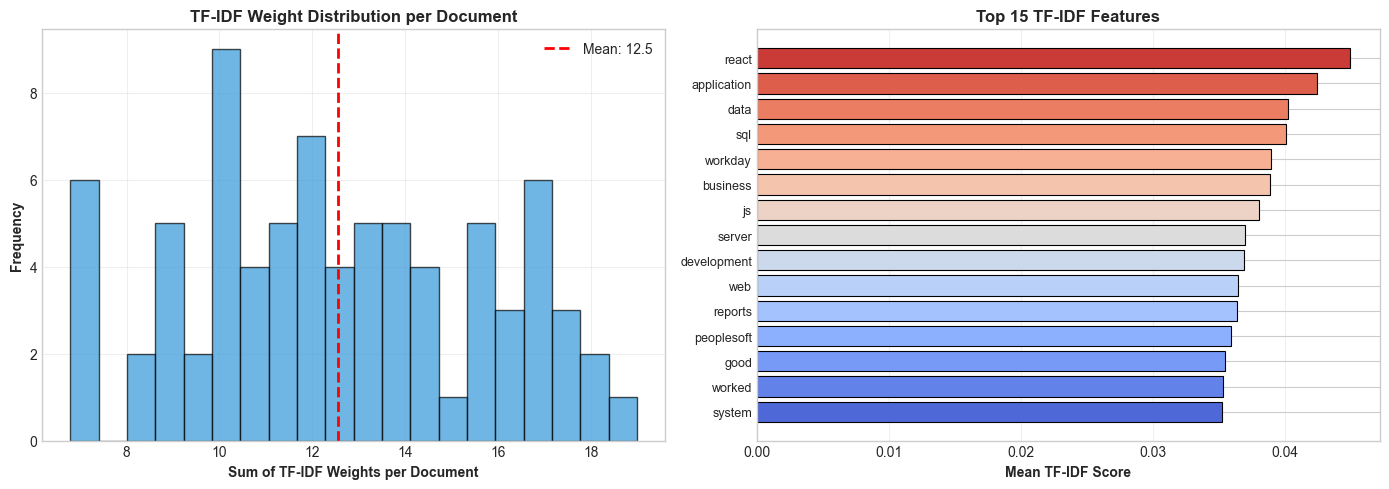

In [19]:
# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    sublinear_tf=True
)

X_tfidf = tfidf.fit_transform(X_text)
feature_names = tfidf.get_feature_names_out()

print("=" * 70)
print("STEP 2: TF-IDF VECTORIZATION")
print("=" * 70)
print(f"\n✓ Text successfully transformed to numerical features")
print(f"  • TF-IDF matrix shape: {X_tfidf.shape}")
print(f"  • Number of documents: {X_tfidf.shape[0]}")
print(f"  • Features extracted: {X_tfidf.shape[1]}")
print(f"  • Matrix density: {X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]) * 100:.2f}%")

# Visualize TF-IDF statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature sparsity distribution
doc_word_counts = np.array(X_tfidf.sum(axis=1)).ravel()
axes[0].hist(doc_word_counts, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(doc_word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {doc_word_counts.mean():.1f}')
axes[0].set_xlabel('Sum of TF-IDF Weights per Document', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('TF-IDF Weight Distribution per Document', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Top TF-IDF features
mean_tfidf = np.array(X_tfidf.mean(axis=0)).ravel()
top_indices = mean_tfidf.argsort()[-15:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_scores = [mean_tfidf[i] for i in top_indices]

colors = sns.color_palette("coolwarm", len(top_features))
axes[1].barh(range(len(top_features)), top_scores[::-1], color=colors, edgecolor='black', linewidth=0.8)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features[::-1], fontsize=9)
axes[1].set_xlabel('Mean TF-IDF Score', fontweight='bold')
axes[1].set_title('Top 15 TF-IDF Features', fontweight='bold', fontsize=12)
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Step 3: Train-Test Split

Split the dataset into training (70%) and testing (30%) sets with stratification to maintain class balance across splits.

STEP 3: TRAIN-TEST SPLIT (70:30 with Stratification)

✓ Data split completed
  • Total samples:    79
  • Training samples: 55 (70%)
  • Testing samples:  24 (30%)


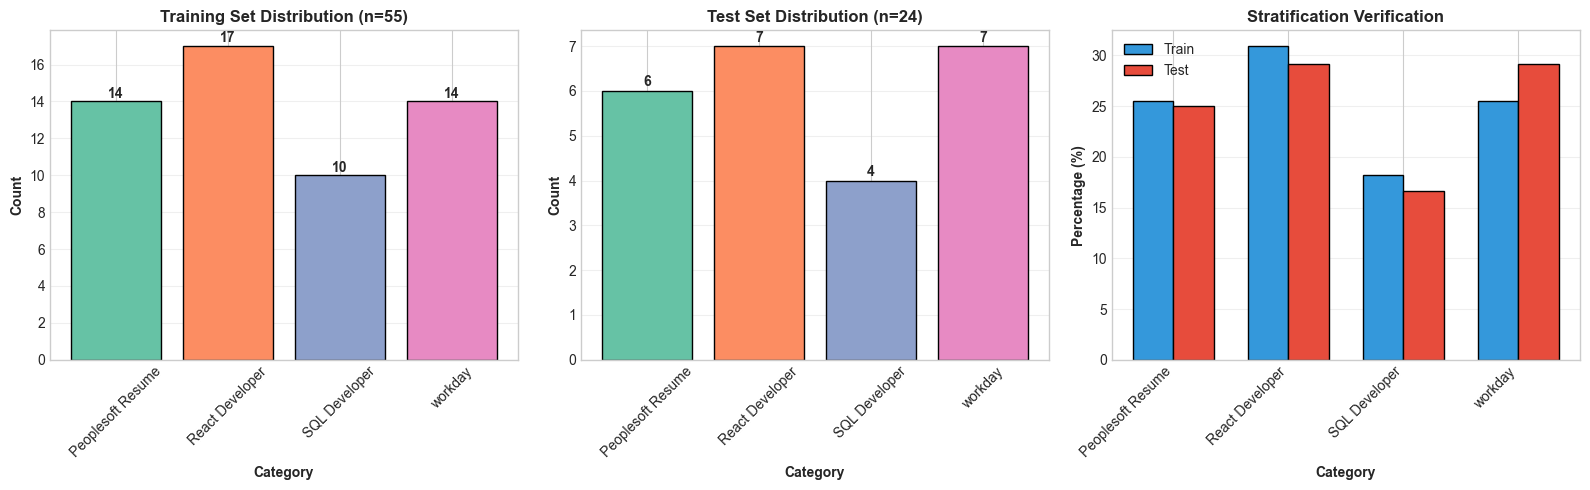


  Class Distribution (Stratified):
  Category             Train        Test        
  --------------------------------------------
  Peoplesoft Resume    14           6           
  React Developer      17           7           
  SQL Developer        10           4           
  workday              14           7           


In [20]:
# Split data: 70% training, 30% testing with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print("=" * 70)
print("STEP 3: TRAIN-TEST SPLIT (70:30 with Stratification)")
print("=" * 70)
print(f"\n✓ Data split completed")
print(f"  • Total samples:    {X_tfidf.shape[0]}")
print(f"  • Training samples: {X_train.shape[0]} (70%)")
print(f"  • Testing samples:  {X_test.shape[0]} (30%)")

# Visualize stratification - verify class balance is preserved
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Training set distribution
train_counts = np.bincount(y_train)
axes[0].bar(le.classes_, train_counts, color=sns.color_palette("Set2", len(le.classes_)), 
            edgecolor='black', linewidth=1)
axes[0].set_xlabel('Category', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].set_title(f'Training Set Distribution (n={len(y_train)})', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(train_counts):
    axes[0].text(i, v + 0.2, str(v), ha='center', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Test set distribution
test_counts = np.bincount(y_test)
axes[1].bar(le.classes_, test_counts, color=sns.color_palette("Set2", len(le.classes_)), 
            edgecolor='black', linewidth=1)
axes[1].set_xlabel('Category', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title(f'Test Set Distribution (n={len(y_test)})', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(test_counts):
    axes[1].text(i, v + 0.1, str(v), ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Comparison - proportions
x = np.arange(len(le.classes_))
width = 0.35
train_pct = train_counts / len(y_train) * 100
test_pct = test_counts / len(y_test) * 100
axes[2].bar(x - width/2, train_pct, width, label='Train', color='#3498db', edgecolor='black')
axes[2].bar(x + width/2, test_pct, width, label='Test', color='#e74c3c', edgecolor='black')
axes[2].set_xlabel('Category', fontweight='bold')
axes[2].set_ylabel('Percentage (%)', fontweight='bold')
axes[2].set_title('Stratification Verification', fontweight='bold', fontsize=12)
axes[2].set_xticks(x)
axes[2].set_xticklabels(le.classes_, rotation=45, ha='right')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n  Class Distribution (Stratified):")
print(f"  {'Category':<20} {'Train':<12} {'Test':<12}")
print(f"  {'-'*44}")
for i, cat in enumerate(le.classes_):
    print(f"  {cat:<20} {train_counts[i]:<12} {test_counts[i]:<12}")

## Step 4: Save Preprocessing Artifacts

Save the TF-IDF vectorizer and label encoder for use in the inference pipeline.

In [21]:
# Save preprocessing artifacts
import joblib
import pickle

prep_dir = Path.cwd() / "preprocessing"
prep_dir.mkdir(parents=True, exist_ok=True)

# Save vectorizer and encoder
joblib.dump(tfidf, prep_dir / "tfidf_vectorizer.pkl")
joblib.dump(le, prep_dir / "label_encoder.pkl")

# Save train/test data as dense arrays
feature_names_list = feature_names if isinstance(feature_names, list) else feature_names.tolist()
pickle.dump({
    'X_train': X_train.toarray(),
    'X_test': X_test.toarray(),
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': feature_names_list
}, open(prep_dir / "train_test_data.pkl", 'wb'))

print("=" * 70)
print("STEP 4: PREPROCESSING ARTIFACTS SAVED")
print("=" * 70)
print(f"\n✓ Files saved to: {prep_dir}")
print(f"  • tfidf_vectorizer.pkl - Text vectorization model")
print(f"  • label_encoder.pkl    - Category label mappings")
print(f"  • train_test_data.pkl  - Prepared datasets for training")

STEP 4: PREPROCESSING ARTIFACTS SAVED

✓ Files saved to: d:\Data Science\NLP\preprocessing
  • tfidf_vectorizer.pkl - Text vectorization model
  • label_encoder.pkl    - Category label mappings
  • train_test_data.pkl  - Prepared datasets for training


---

# Model Training & Evaluation

## Model Selection Strategy

We will train and evaluate four classification models suitable for text classification:

| Model | Description | Strengths |
|-------|-------------|-----------|
| **K-Nearest Neighbors (KNN)** | Instance-based learning | Simple, no training phase, works well with high-dimensional sparse data |
| **Support Vector Machine (SVM)** | Finds optimal hyperplane | Excellent for text classification, handles high dimensions |
| **Random Forest** | Ensemble of decision trees | Robust, handles feature interactions, provides feature importance |
| **Naive Bayes** | Probabilistic classifier | Fast, works well with sparse text data, strong baseline |

Each model will be evaluated using:
- **Stratified K-Fold Cross-Validation** (5 folds) for robust performance estimation
- **Multiple Metrics**: Accuracy, F1-Score, Precision, Recall

In [22]:
import pickle
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                            f1_score, precision_score, recall_score, roc_curve, auc)
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Load preprocessed data and objects from preprocessing folder
prep_dir = Path.cwd() / "preprocessing"

# Load train/test data
with open(prep_dir / "train_test_data.pkl", 'rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    feature_names = data['feature_names']

# Load vectorizer and encoder
tfidf = joblib.load(prep_dir / "tfidf_vectorizer.pkl")
le = joblib.load(prep_dir / "label_encoder.pkl")

print("=" * 70)
print("DATA LOADING FOR MODEL TRAINING")
print("=" * 70)
print(f"\n✓ Data loaded successfully from preprocessing folder")
print(f"  • Training set: {X_train.shape}")
print(f"  • Test set:     {X_test.shape}")
print(f"  • Categories:   {list(le.classes_)}")
print(f"  • Features:     {len(feature_names)}")

DATA LOADING FOR MODEL TRAINING

✓ Data loaded successfully from preprocessing folder
  • Training set: (55, 1000)
  • Test set:     (24, 1000)
  • Categories:   ['Peoplesoft Resume', 'React Developer', 'SQL Developer', 'workday']
  • Features:     1000


## Use Tuned Models for Training

Use the hyperparameter-tuned models for training and evaluation.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

print("=" * 100)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("=" * 100)

# Define hyperparameter grids for each model
param_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'metric': ['cosine', 'euclidean'],
        'weights': ['uniform', 'distance']
    },
    'SVM': {
        'C': [0.1, 1.0, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 3, 5],
        'max_features': ['sqrt', 'log2']
    },
    'Naive Bayes': {
        'alpha': [0.01, 0.1, 1.0],
        'fit_prior': [True, False]
    }
}

# Store best models and parameters
best_models = {}
best_params = {}
grid_results = {}

# Perform GridSearchCV for each model
cv_tuning = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name in ['KNN', 'SVM', 'Random Forest', 'Naive Bayes']:
    print(f"\n{'='*100}")
    print(f"Tuning: {model_name}")
    print(f"{'='*100}")
    
    # Initialize base model
    if model_name == 'KNN':
        base_model = KNeighborsClassifier(n_jobs=-1)
    elif model_name == 'SVM':
        base_model = SVC(random_state=42, probability=True)
    elif model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    else:  # Naive Bayes
        base_model = MultinomialNB()
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grids[model_name],
        cv=cv_tuning,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    print(f"Searching {len(list(__import__('itertools').product(*param_grids[model_name].values())))} parameter combinations...")
    grid_search.fit(X_train, y_train)
    
    # Store results
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    grid_results[model_name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'mean_test_scores': grid_search.cv_results_['mean_test_score'],
        'std_test_scores': grid_search.cv_results_['std_test_score']
    }
    
    print(f"Best F1-Score (CV): {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")

# Display summary comparison
print(f"\n{'='*100}")
print("HYPERPARAMETER TUNING SUMMARY")
print(f"{'='*100}\n")

summary_data = []
for model_name in ['KNN', 'SVM', 'Random Forest', 'Naive Bayes']:
    summary_data.append({
        'Model': model_name,
        'Best CV F1-Score': f"{grid_results[model_name]['best_score']:.4f}",
        'Best Parameters': str(best_params[model_name])
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Use the best models for cross-validation training
models = best_models

print(f"\n{'='*70}")
print("✓ TUNED MODELS SELECTED FOR CROSS-VALIDATION TRAINING")
print(f"{'='*70}")
print(f"\n{len(models)} hyperparameter-optimized models ready for evaluation:\n")

for name, model in models.items():
    print(f"  • {name:15s} with optimized parameters")
    if name in best_params:
        for param, value in best_params[name].items():
            print(f"      └─ {param}: {value}")

HYPERPARAMETER TUNING WITH GRIDSEARCHCV

Tuning: KNN
Searching 16 parameter combinations...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best F1-Score (CV): 1.0000
Best Parameters: {'metric': 'cosine', 'n_neighbors': 3, 'weights': 'uniform'}

Tuning: SVM
Searching 12 parameter combinations...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best F1-Score (CV): 1.0000
Best Parameters: {'metric': 'cosine', 'n_neighbors': 3, 'weights': 'uniform'}

Tuning: SVM
Searching 12 parameter combinations...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best F1-Score (CV): 1.0000
Best Parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}

Tuning: Random Forest
Searching 54 parameter combinations...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best F1-Score (CV): 1.0000
Best Parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}

Tuning: Random Forest
Searching 54 parameter combinations...
Fitting 5 folds for each of 54 candidat

## Cross-Validation Training with Tuned Models

Train all hyperparameter-tuned models using Stratified 5-Fold Cross-Validation to obtain robust performance estimates.

**Why Stratified K-Fold?**
- Preserves class distribution in each fold
- Provides reliable performance estimation on small datasets
- Reduces variance in performance metrics

CROSS-VALIDATION TRAINING (5-Fold Stratified)

Model                Accuracy           F1-Score           Time (s)  
----------------------------------------------------------------------
KNN                  1.0000 ± 0.0000   1.0000 ± 0.0000   0.13
SVM                  1.0000 ± 0.0000   1.0000 ± 0.0000   0.05
Random Forest        1.0000 ± 0.0000   1.0000 ± 0.0000   0.60
Naive Bayes          1.0000 ± 0.0000   1.0000 ± 0.0000   0.04
----------------------------------------------------------------------

✓ All models trained successfully!
Random Forest        1.0000 ± 0.0000   1.0000 ± 0.0000   0.60
Naive Bayes          1.0000 ± 0.0000   1.0000 ± 0.0000   0.04
----------------------------------------------------------------------

✓ All models trained successfully!


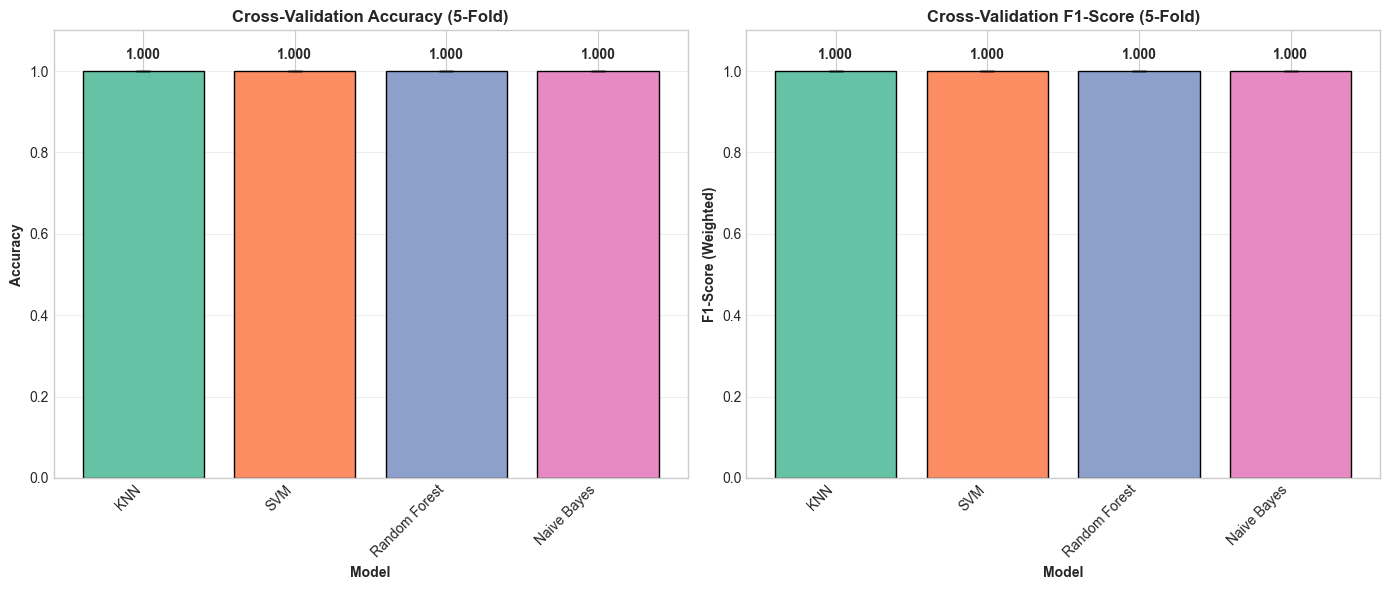

In [24]:
# Train models with Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

cv_results = {}
trained_models = {}
training_times = {}

print("=" * 70)
print("CROSS-VALIDATION TRAINING (5-Fold Stratified)")
print("=" * 70)
print(f"\n{'Model':<20} {'Accuracy':<18} {'F1-Score':<18} {'Time (s)':<10}")
print("-" * 70)

for name, model in models.items():
    start_time = time.time()
    
    # Perform cross-validation with multiple metrics
    cv_scores = cross_validate(
        model, X_train, y_train, 
        cv=cv, 
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Store CV results
    cv_results[name] = cv_scores
    
    # Train final model on full training set
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    training_time = time.time() - start_time
    training_times[name] = training_time
    
    acc_mean = cv_scores['test_accuracy'].mean()
    acc_std = cv_scores['test_accuracy'].std()
    f1_mean = cv_scores['test_f1_weighted'].mean()
    f1_std = cv_scores['test_f1_weighted'].std()
    
    print(f"{name:<20} {acc_mean:.4f} ± {acc_std:.4f}   {f1_mean:.4f} ± {f1_std:.4f}   {training_time:.2f}")

print("-" * 70)
print(f"\n✓ All models trained successfully!")

# Visualize cross-validation results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# CV Accuracy comparison
model_names = list(cv_results.keys())
acc_means = [cv_results[m]['test_accuracy'].mean() for m in model_names]
acc_stds = [cv_results[m]['test_accuracy'].std() for m in model_names]

colors = sns.color_palette("Set2", len(model_names))
x_pos = np.arange(len(model_names))

axes[0].bar(x_pos, acc_means, yerr=acc_stds, capsize=5, color=colors, edgecolor='black', linewidth=1)
axes[0].set_xlabel('Model', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Cross-Validation Accuracy (5-Fold)', fontweight='bold', fontsize=12)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].set_ylim([0, 1.1])
for i, (m, s) in enumerate(zip(acc_means, acc_stds)):
    axes[0].text(i, m + s + 0.03, f'{m:.3f}', ha='center', fontweight='bold', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# CV F1-Score comparison
f1_means = [cv_results[m]['test_f1_weighted'].mean() for m in model_names]
f1_stds = [cv_results[m]['test_f1_weighted'].std() for m in model_names]

axes[1].bar(x_pos, f1_means, yerr=f1_stds, capsize=5, color=colors, edgecolor='black', linewidth=1)
axes[1].set_xlabel('Model', fontweight='bold')
axes[1].set_ylabel('F1-Score (Weighted)', fontweight='bold')
axes[1].set_title('Cross-Validation F1-Score (5-Fold)', fontweight='bold', fontsize=12)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1].set_ylim([0, 1.1])
for i, (m, s) in enumerate(zip(f1_means, f1_stds)):
    axes[1].text(i, m + s + 0.03, f'{m:.3f}', ha='center', fontweight='bold', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---

## Individual Model Evaluation on Test Set

Evaluate each trained model on the held-out test set with detailed visualizations including:
- **Confusion Matrix** - Shows prediction accuracy per class
- **Classification Metrics** - Precision, Recall, F1-Score per category
- **Predicted Probability Distribution** - Confidence of predictions

INDIVIDUAL MODEL EVALUATION ON TEST SET

────────────────────────────────────────────────────────────────────────────────────────────────────
  KNN
────────────────────────────────────────────────────────────────────────────────────────────────────

  Test Accuracy: 1.0000 | F1-Score: 1.0000 | Precision: 1.0000 | Recall: 1.0000

                   precision    recall  f1-score   support

Peoplesoft Resume     1.0000    1.0000    1.0000         6
  React Developer     1.0000    1.0000    1.0000         7
    SQL Developer     1.0000    1.0000    1.0000         4
          workday     1.0000    1.0000    1.0000         7

         accuracy                         1.0000        24
        macro avg     1.0000    1.0000    1.0000        24
     weighted avg     1.0000    1.0000    1.0000        24



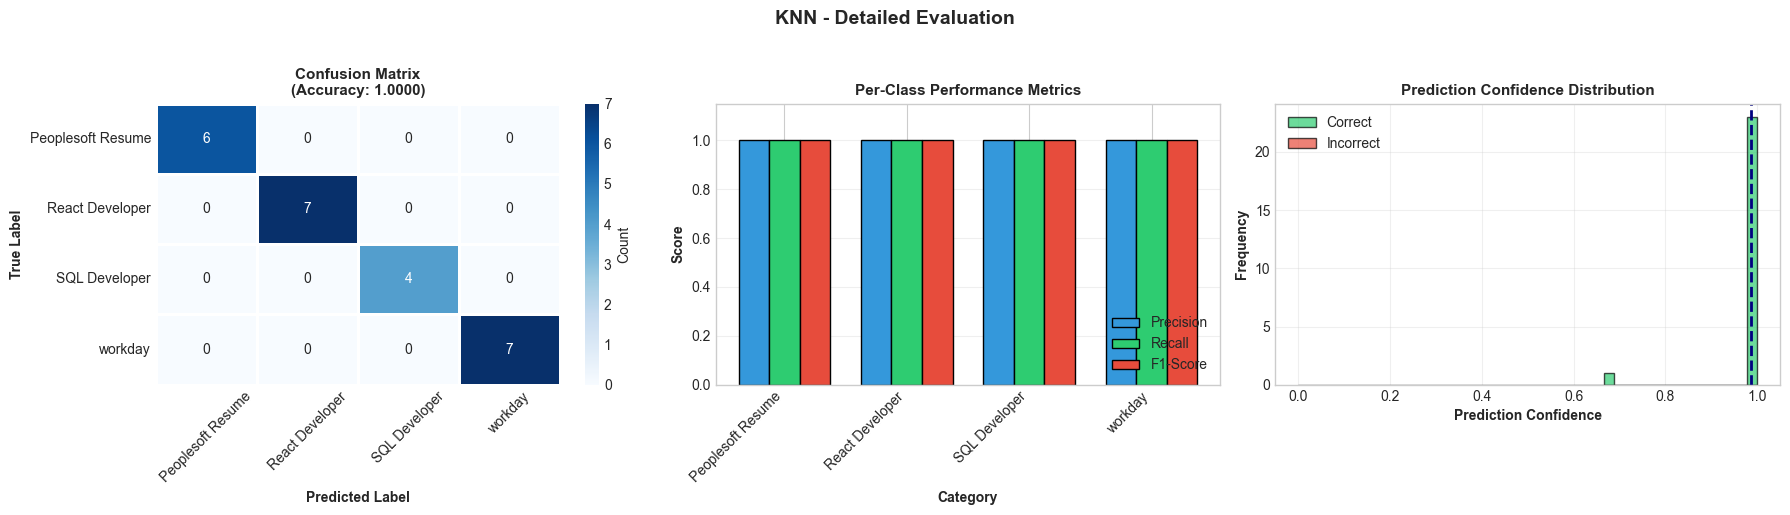


────────────────────────────────────────────────────────────────────────────────────────────────────
  SVM
────────────────────────────────────────────────────────────────────────────────────────────────────

  Test Accuracy: 1.0000 | F1-Score: 1.0000 | Precision: 1.0000 | Recall: 1.0000

                   precision    recall  f1-score   support

Peoplesoft Resume     1.0000    1.0000    1.0000         6
  React Developer     1.0000    1.0000    1.0000         7
    SQL Developer     1.0000    1.0000    1.0000         4
          workday     1.0000    1.0000    1.0000         7

         accuracy                         1.0000        24
        macro avg     1.0000    1.0000    1.0000        24
     weighted avg     1.0000    1.0000    1.0000        24



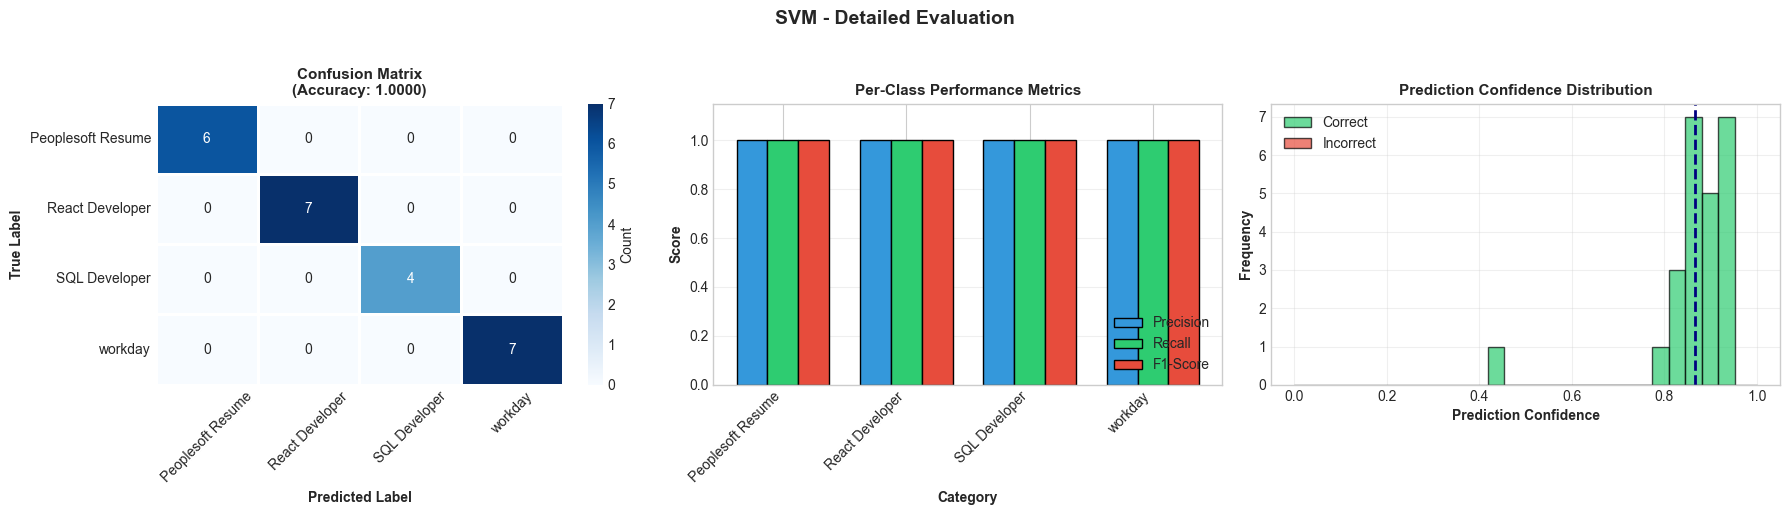


────────────────────────────────────────────────────────────────────────────────────────────────────
  RANDOM FOREST
────────────────────────────────────────────────────────────────────────────────────────────────────

  Test Accuracy: 1.0000 | F1-Score: 1.0000 | Precision: 1.0000 | Recall: 1.0000

                   precision    recall  f1-score   support

Peoplesoft Resume     1.0000    1.0000    1.0000         6
  React Developer     1.0000    1.0000    1.0000         7
    SQL Developer     1.0000    1.0000    1.0000         4
          workday     1.0000    1.0000    1.0000         7

         accuracy                         1.0000        24
        macro avg     1.0000    1.0000    1.0000        24
     weighted avg     1.0000    1.0000    1.0000        24



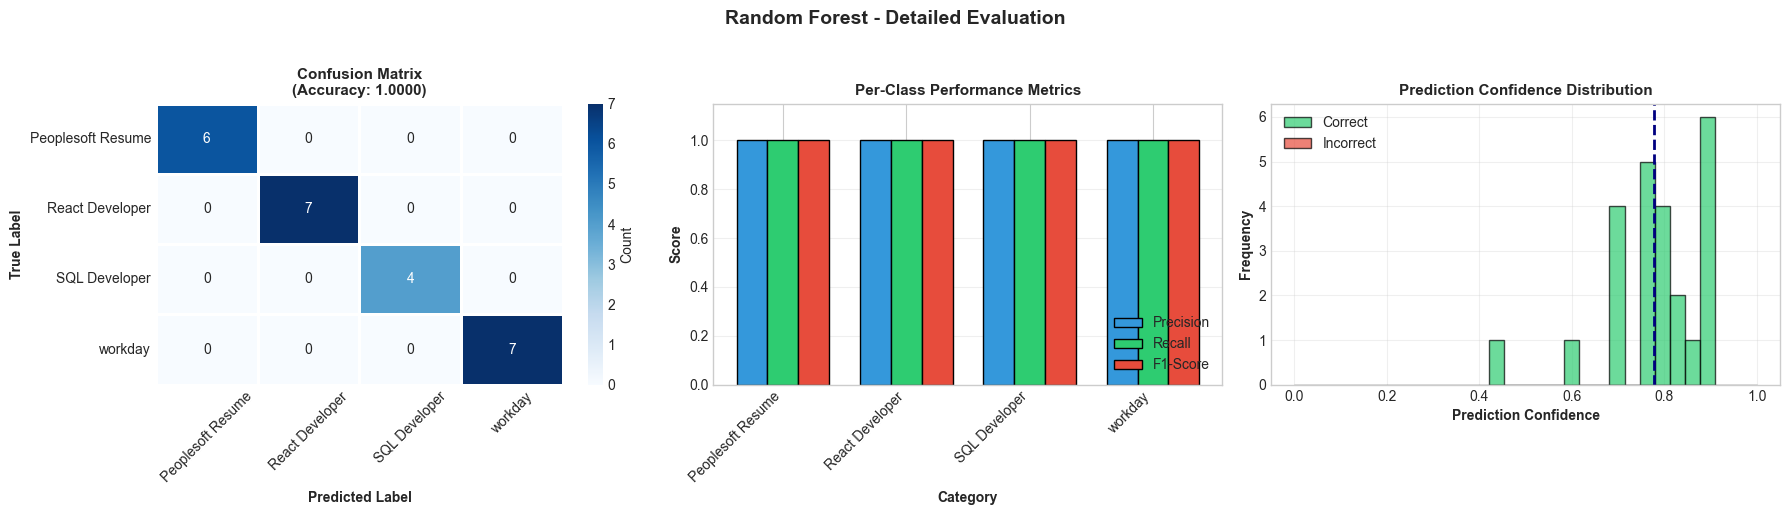


────────────────────────────────────────────────────────────────────────────────────────────────────
  NAIVE BAYES
────────────────────────────────────────────────────────────────────────────────────────────────────

  Test Accuracy: 1.0000 | F1-Score: 1.0000 | Precision: 1.0000 | Recall: 1.0000

                   precision    recall  f1-score   support

Peoplesoft Resume     1.0000    1.0000    1.0000         6
  React Developer     1.0000    1.0000    1.0000         7
    SQL Developer     1.0000    1.0000    1.0000         4
          workday     1.0000    1.0000    1.0000         7

         accuracy                         1.0000        24
        macro avg     1.0000    1.0000    1.0000        24
     weighted avg     1.0000    1.0000    1.0000        24



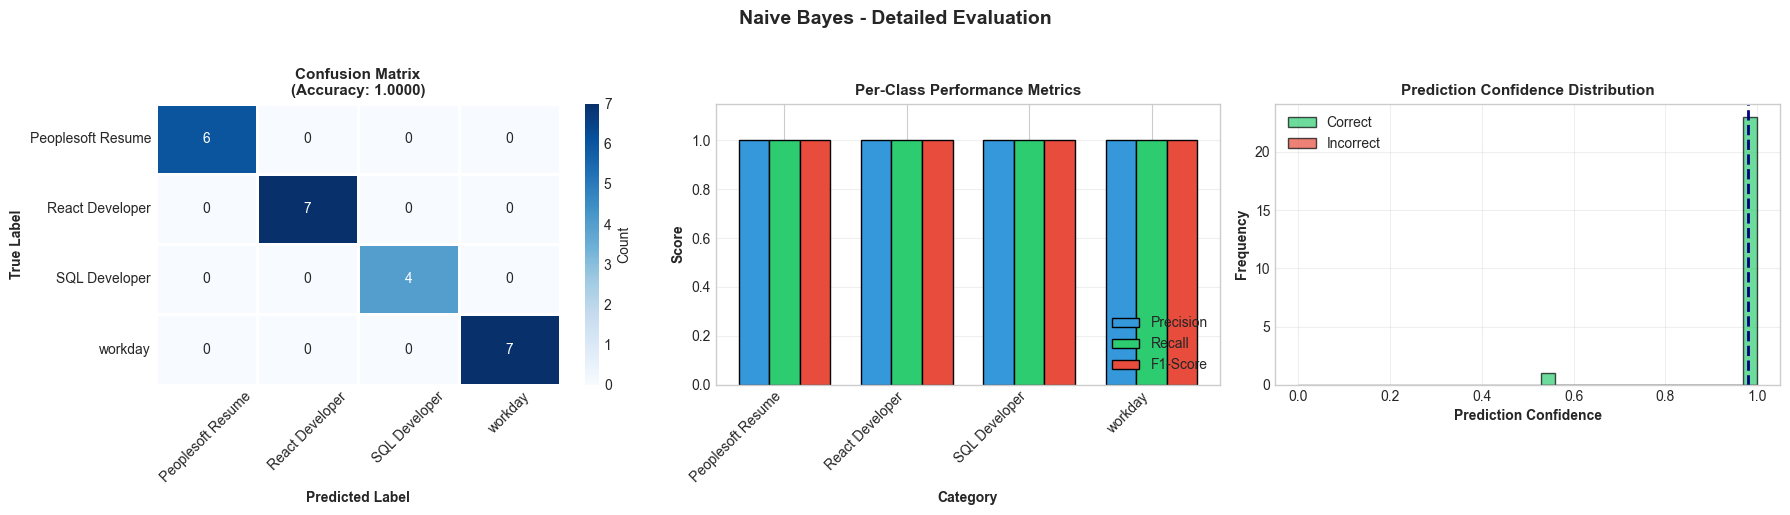


✓ All models evaluated on test set


In [25]:
# Evaluate each model on test set with detailed visualizations
test_results = {}

print("=" * 100)
print("INDIVIDUAL MODEL EVALUATION ON TEST SET")
print("=" * 100)

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    test_results[name] = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_proba
    }
    
    # Print classification report
    print(f"\n{'─' * 100}")
    print(f"  {name.upper()}")
    print(f"{'─' * 100}")
    print(f"\n  Test Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))
    
    # Create visualization grid for each model
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{name} - Detailed Evaluation', fontsize=14, fontweight='bold', y=1.02)
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=le.classes_, yticklabels=le.classes_,
                cbar_kws={'label': 'Count'}, linewidths=1, linecolor='white')
    axes[0].set_title(f'Confusion Matrix\n(Accuracy: {accuracy:.4f})', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('True Label', fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    # 2. Per-Class Metrics
    report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    metrics_df = pd.DataFrame({
        'Precision': [report_dict[c]['precision'] for c in le.classes_],
        'Recall': [report_dict[c]['recall'] for c in le.classes_],
        'F1-Score': [report_dict[c]['f1-score'] for c in le.classes_]
    }, index=le.classes_)
    
    x = np.arange(len(le.classes_))
    width = 0.25
    axes[1].bar(x - width, metrics_df['Precision'], width, label='Precision', color='#3498db', edgecolor='black')
    axes[1].bar(x, metrics_df['Recall'], width, label='Recall', color='#2ecc71', edgecolor='black')
    axes[1].bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', color='#e74c3c', edgecolor='black')
    axes[1].set_xlabel('Category', fontweight='bold')
    axes[1].set_ylabel('Score', fontweight='bold')
    axes[1].set_title('Per-Class Performance Metrics', fontsize=11, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(le.classes_, rotation=45, ha='right')
    axes[1].legend(loc='lower right')
    axes[1].set_ylim([0, 1.15])
    axes[1].grid(axis='y', alpha=0.3)
    
    # 3. Prediction Confidence Distribution
    if y_proba is not None:
        max_proba = np.max(y_proba, axis=1)
        correct_mask = y_pred == y_test
        
        axes[2].hist(max_proba[correct_mask], bins=15, alpha=0.7, label='Correct', 
                     color='#2ecc71', edgecolor='black')
        axes[2].hist(max_proba[~correct_mask], bins=15, alpha=0.7, label='Incorrect', 
                     color='#e74c3c', edgecolor='black')
        axes[2].set_xlabel('Prediction Confidence', fontweight='bold')
        axes[2].set_ylabel('Frequency', fontweight='bold')
        axes[2].set_title('Prediction Confidence Distribution', fontsize=11, fontweight='bold')
        axes[2].legend()
        axes[2].axvline(max_proba.mean(), color='navy', linestyle='--', linewidth=2, 
                        label=f'Mean: {max_proba.mean():.2f}')
        axes[2].grid(alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'Probabilities not available', ha='center', va='center', fontsize=12)
        axes[2].set_title('Prediction Confidence', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print(f"\n{'=' * 100}")
print("✓ All models evaluated on test set")
print(f"{'=' * 100}")

---

## Comprehensive Model Comparison

Compare all models using multiple metrics to identify the best performer for resume classification.

MODEL COMPARISON & BEST MODEL SELECTION

📊 Model Performance Summary (Ranked by Total Score)
----------------------------------------------------------------------------------------------------
        Model  CV Accuracy  CV F1-Score  Test Accuracy  Test F1-Score  Test Precision  Test Recall  Total Score
          KNN          1.0          1.0            1.0            1.0             1.0          1.0          1.0
          SVM          1.0          1.0            1.0            1.0             1.0          1.0          1.0
Random Forest          1.0          1.0            1.0            1.0             1.0          1.0          1.0
  Naive Bayes          1.0          1.0            1.0            1.0             1.0          1.0          1.0




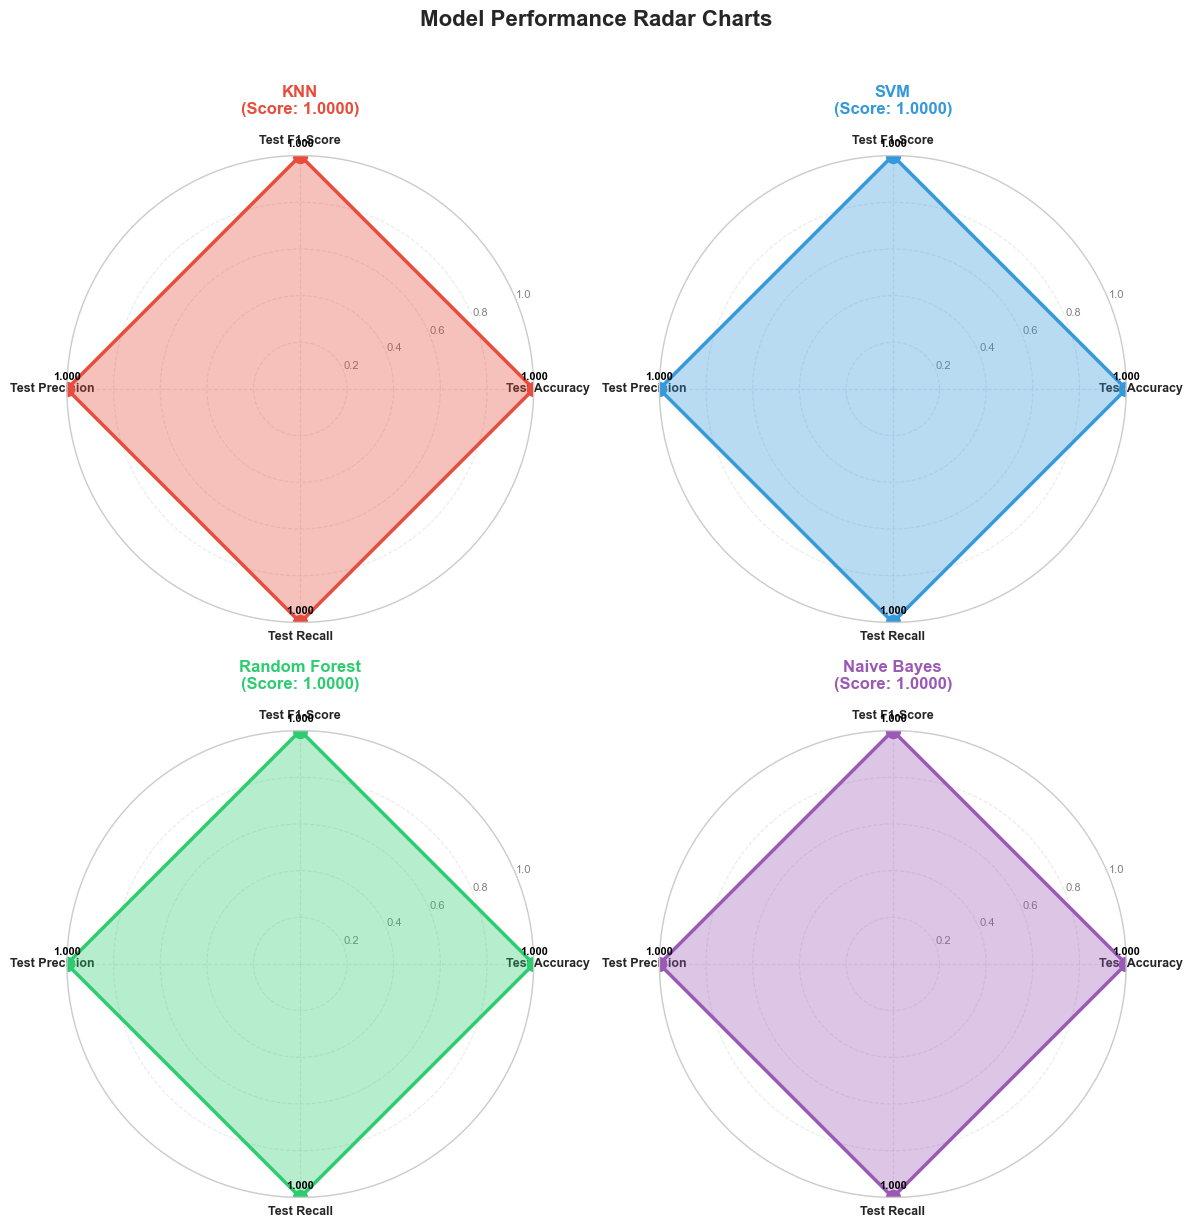

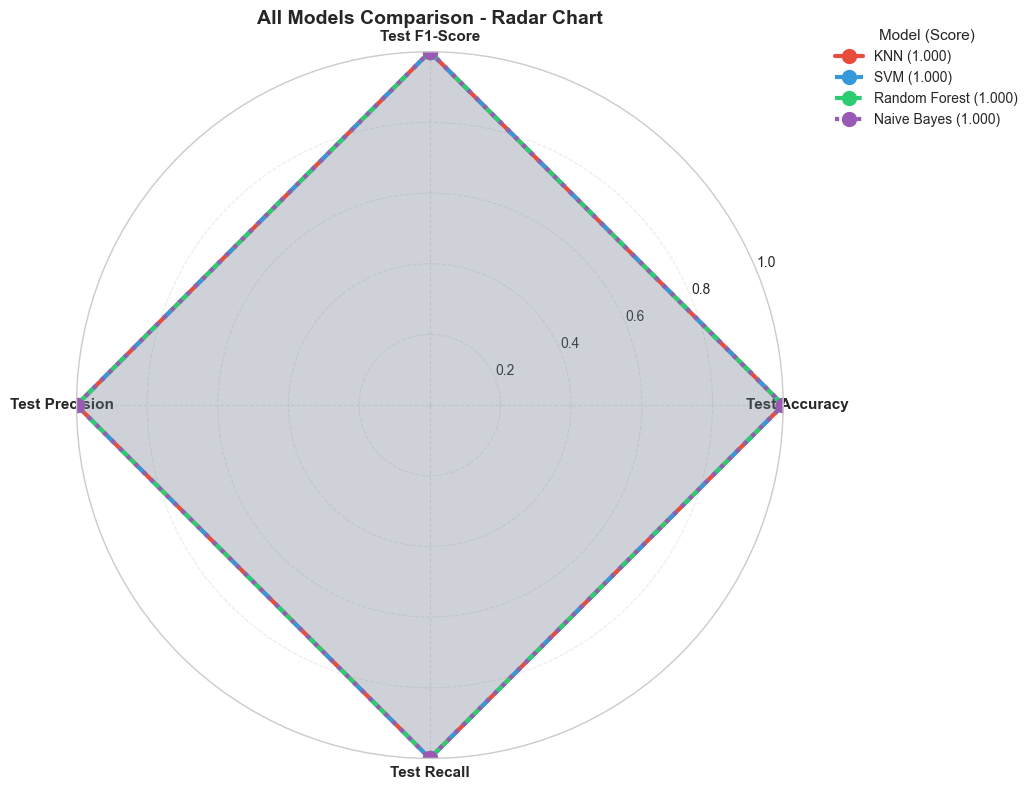

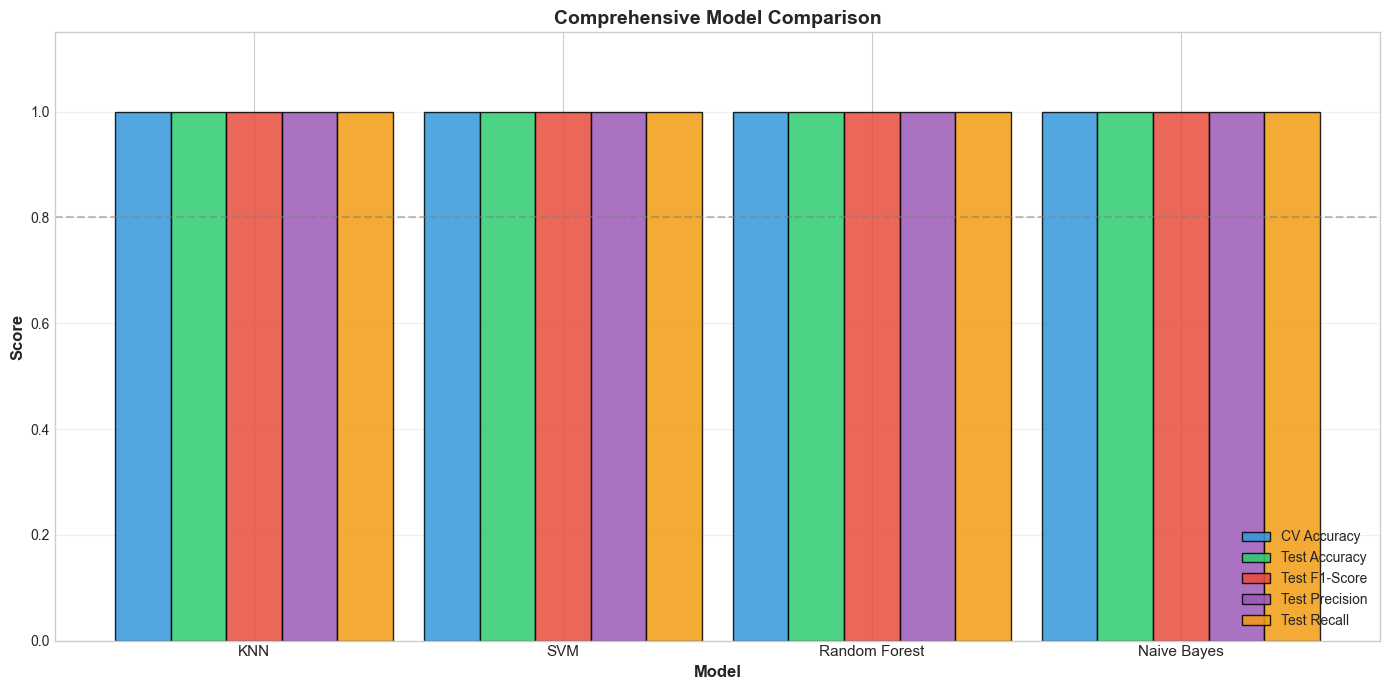

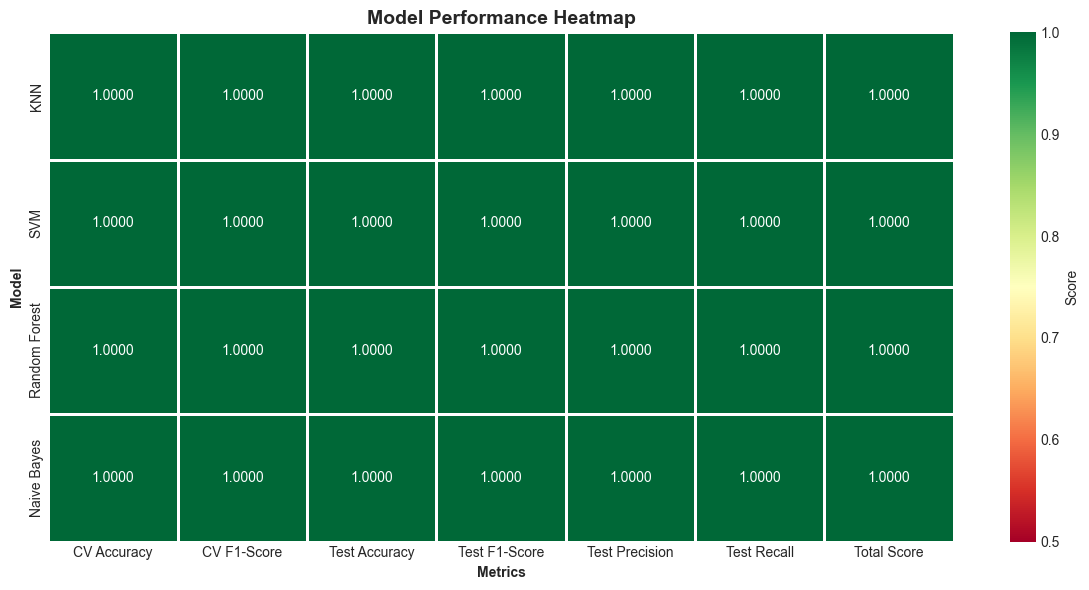

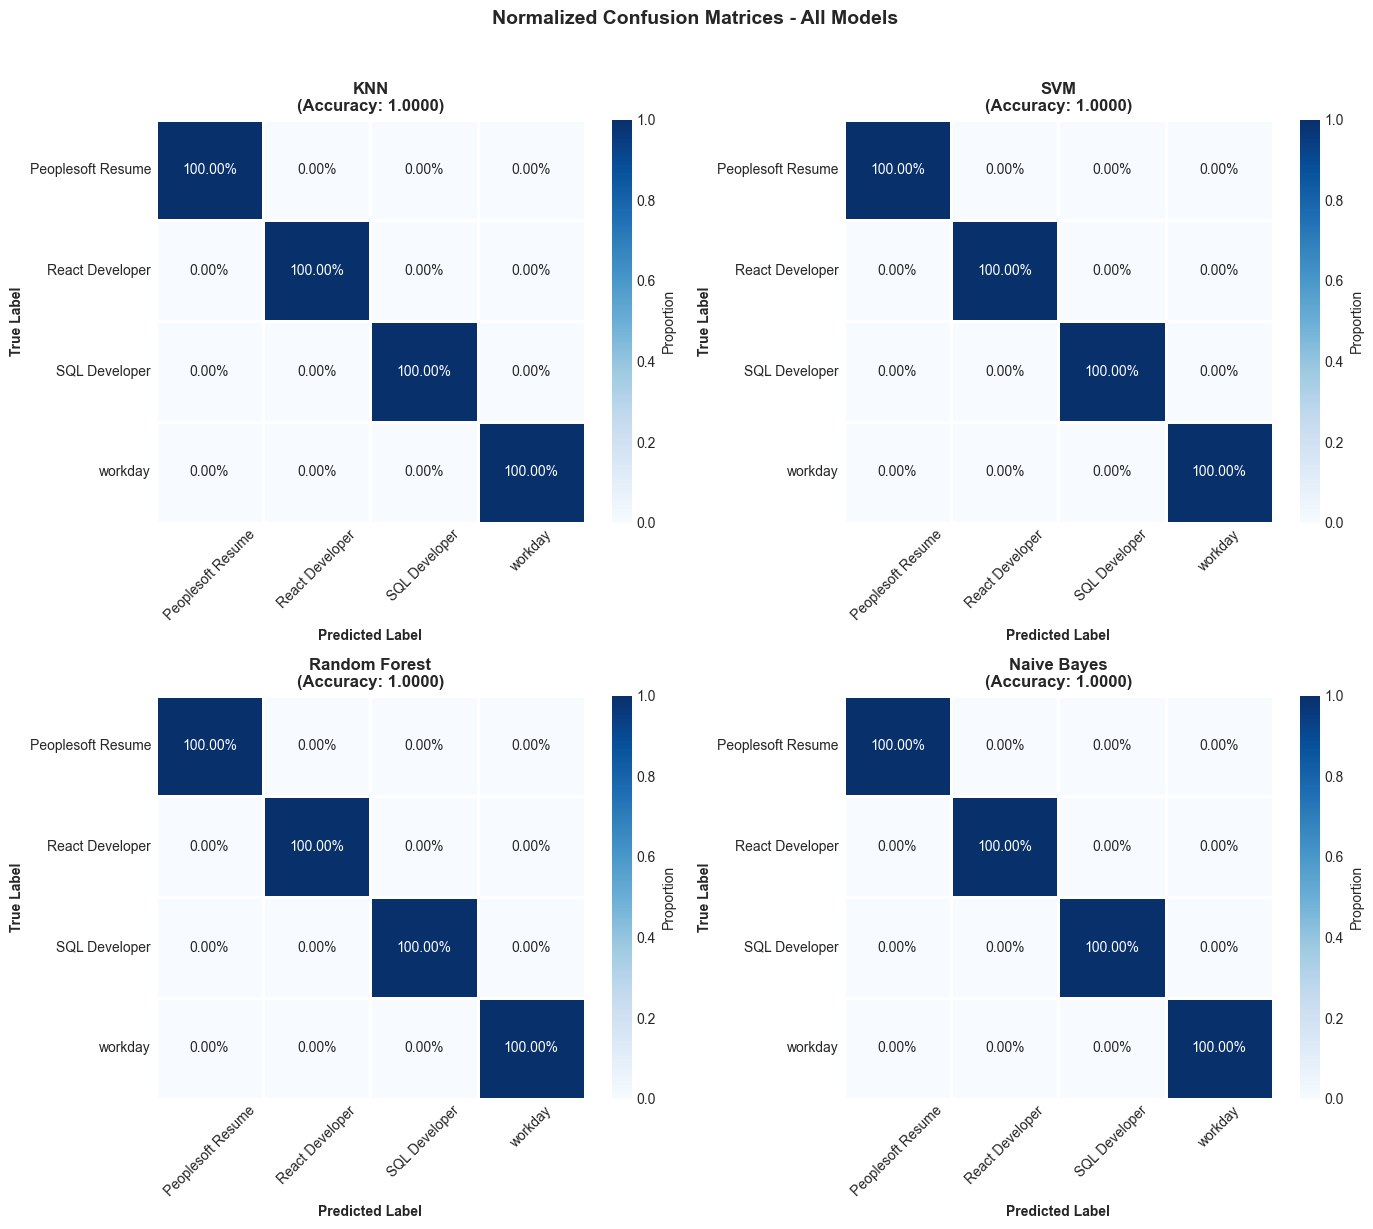

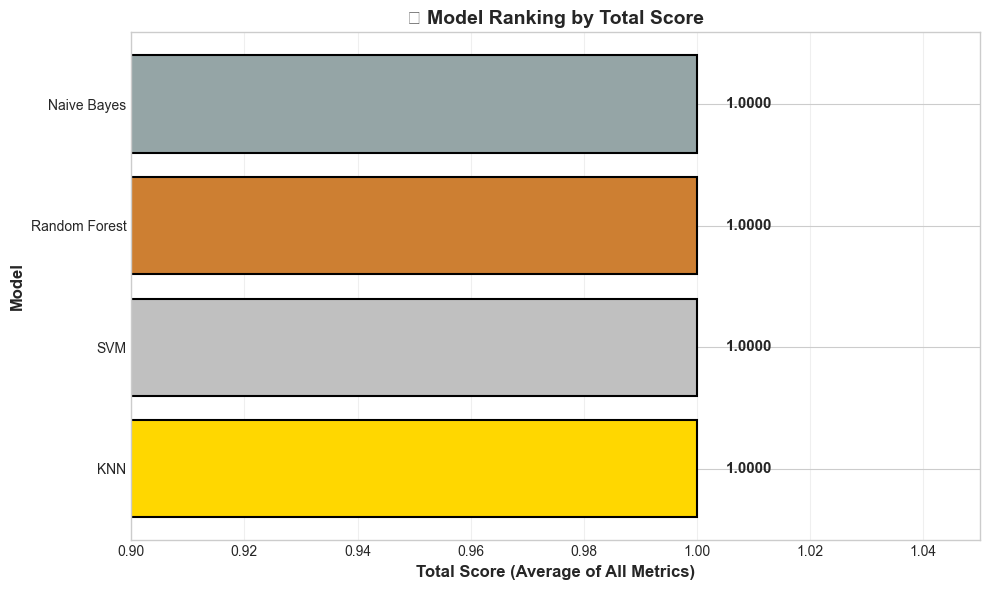


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🏆 BEST MODEL SELECTED: KNN
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Performance Summary:
  • Test Accuracy:    1.0000
  • Test F1-Score:    1.0000
  • Test Precision:   1.0000
  • Test Recall:      1.0000
  • Total Score:      1.0000

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [26]:
# Comprehensive Model Comparison
print("=" * 100)
print("MODEL COMPARISON & BEST MODEL SELECTION")
print("=" * 100)

# Create comparison dataframe
comparison_data = []
for name in trained_models.keys():
    cv_acc = cv_results[name]['test_accuracy'].mean()
    cv_f1 = cv_results[name]['test_f1_weighted'].mean()
    test_acc = test_results[name]['accuracy']
    test_f1 = test_results[name]['f1']
    test_prec = test_results[name]['precision']
    test_rec = test_results[name]['recall']
    
    comparison_data.append({
        'Model': name,
        'CV Accuracy': cv_acc,
        'CV F1-Score': cv_f1,
        'Test Accuracy': test_acc,
        'Test F1-Score': test_f1,
        'Test Precision': test_prec,
        'Test Recall': test_rec,
        'Training Time (s)': training_times[name]
    })

comparison_df = pd.DataFrame(comparison_data)

# Calculate total score (average of key metrics)
comparison_df['Total Score'] = (comparison_df['Test Accuracy'] + comparison_df['Test F1-Score'] + 
                                 comparison_df['Test Precision'] + comparison_df['Test Recall']) / 4

comparison_df = comparison_df.sort_values('Total Score', ascending=False).reset_index(drop=True)

print("\n📊 Model Performance Summary (Ranked by Total Score)")
print("-" * 100)
display_cols = ['Model', 'CV Accuracy', 'CV F1-Score', 'Test Accuracy', 'Test F1-Score', 
                'Test Precision', 'Test Recall', 'Total Score']
print(comparison_df[display_cols].to_string(index=False))

# ========== VISUALIZATION 1: Radar Charts (One per Model - No Overlap!) ==========
print("\n")
radar_metrics = ['Test Accuracy', 'Test F1-Score', 'Test Precision', 'Test Recall']
num_metrics = len(radar_metrics)
distinct_colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']  # Red, Blue, Green, Purple

# Create a 2x2 grid of radar charts - one for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(polar=True))
axes = axes.ravel()

# Calculate angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

for idx, row in comparison_df.iterrows():
    ax = axes[idx]
    model_name = row['Model']
    color = distinct_colors[idx]
    
    # Get values for this model
    values = [row[m] for m in radar_metrics]
    values += values[:1]  # Close the polygon
    
    # Plot the radar chart
    ax.plot(angles, values, 'o-', linewidth=2.5, markersize=10, color=color, label=model_name)
    ax.fill(angles, values, alpha=0.35, color=color)
    
    # Customize the chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_metrics, fontsize=9, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8, color='gray')
    ax.set_title(f'{model_name}\n(Score: {row["Total Score"]:.4f})', fontsize=12, fontweight='bold', 
                 color=color, pad=15)
    ax.grid(True, alpha=0.4, linestyle='--')
    
    # Add value annotations at each point
    for angle, value, metric in zip(angles[:-1], values[:-1], radar_metrics):
        ax.annotate(f'{value:.3f}', xy=(angle, value), fontsize=8, fontweight='bold',
                   ha='center', va='bottom', color='black',
                   xytext=(0, 5), textcoords='offset points')

plt.suptitle('Model Performance Radar Charts', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ========== VISUALIZATION 2: Combined Radar Chart (All Models Overlayed) ==========
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

for idx, row in comparison_df.iterrows():
    model_name = row['Model']
    color = distinct_colors[idx]
    
    values = [row[m] for m in radar_metrics]
    values += values[:1]
    
    # Use different line styles to differentiate overlapping lines
    line_styles = ['-', '--', '-.', ':']
    ax.plot(angles, values, line_styles[idx], linewidth=3, markersize=10, marker='o',
            color=color, label=f'{model_name} ({row["Total Score"]:.3f})')
    ax.fill(angles, values, alpha=0.1, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics, fontsize=11, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_title('All Models Comparison - Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.05), fontsize=10, title='Model (Score)',
          title_fontsize=11, framealpha=0.95, edgecolor='black')
ax.grid(True, alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()

# ========== VISUALIZATION 3: Grouped Bar Chart ==========
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(comparison_df))
width = 0.18
metrics_to_plot = ['CV Accuracy', 'Test Accuracy', 'Test F1-Score', 'Test Precision', 'Test Recall']
colors_bar = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors_bar)):
    offset = width * (i - len(metrics_to_plot)/2 + 0.5)
    bars = ax.bar(x + offset, comparison_df[metric], width, label=metric, color=color, edgecolor='black', alpha=0.85)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comprehensive Model Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], fontsize=11)
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim([0, 1.15])
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='80% Threshold')
plt.tight_layout()
plt.show()

# ========== VISUALIZATION 4: Heatmap of All Metrics ==========
fig, ax = plt.subplots(figsize=(12, 6))

heatmap_data = comparison_df[['Model', 'CV Accuracy', 'CV F1-Score', 'Test Accuracy', 
                               'Test F1-Score', 'Test Precision', 'Test Recall', 'Total Score']].copy()
heatmap_data = heatmap_data.set_index('Model')

sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', ax=ax, 
            linewidths=1, linecolor='white', cbar_kws={'label': 'Score'},
            vmin=0.5, vmax=1.0)
ax.set_title('Model Performance Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Model', fontweight='bold')
plt.tight_layout()
plt.show()

# ========== VISUALIZATION 5: Confusion Matrix Comparison ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(trained_models.items()):
    cm = confusion_matrix(y_test, test_results[name]['predictions'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],
                xticklabels=le.classes_, yticklabels=le.classes_,
                cbar_kws={'label': 'Proportion'}, linewidths=1, linecolor='white')
    axes[idx].set_title(f'{name}\n(Accuracy: {test_results[name]["accuracy"]:.4f})', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Normalized Confusion Matrices - All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
# Save for deployment
models_dir = Path.cwd() / "models"
models_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(models_dir / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== VISUALIZATION 6: Total Score Ranking ==========
fig, ax = plt.subplots(figsize=(10, 6))

colors_rank = ['#FFD700' if i == 0 else '#C0C0C0' if i == 1 else '#CD7F32' if i == 2 else '#95a5a6' 
               for i in range(len(comparison_df))]

bars = ax.barh(comparison_df['Model'], comparison_df['Total Score'], color=colors_rank, 
               edgecolor='black', linewidth=1.5)
ax.set_xlabel('Total Score (Average of All Metrics)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('🏆 Model Ranking by Total Score', fontsize=14, fontweight='bold')
ax.set_xlim([min(comparison_df['Total Score']) * 0.9, max(comparison_df['Total Score']) * 1.05])

for bar, score in zip(bars, comparison_df['Total Score']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{score:.4f}', va='center', fontweight='bold', fontsize=11)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

# Extract predictions and probabilities from the best model
y_pred_best = test_results[best_model_name]['predictions']
y_proba_best = test_results[best_model_name]['probabilities']

print(f"\n{'━' * 100}")
print(f"🏆 BEST MODEL SELECTED: {best_model_name.upper()}")
print(f"{'━' * 100}")
print(f"\n  Performance Summary:")
print(f"  • Test Accuracy:    {test_results[best_model_name]['accuracy']:.4f}")
print(f"  • Test F1-Score:    {test_results[best_model_name]['f1']:.4f}")
print(f"  • Test Precision:   {test_results[best_model_name]['precision']:.4f}")
print(f"  • Test Recall:      {test_results[best_model_name]['recall']:.4f}")
print(f"  • Total Score:      {comparison_df.iloc[0]['Total Score']:.4f}")
print(f"\n{'━' * 100}")

---

## Sample Predictions Demo

Demonstrate the trained model on actual resume samples from the test set. This shows:
- Category assignments for test resumes
- Confidence scores and probability distributions
- Model prediction reliability

SAMPLE PREDICTIONS DEMONSTRATION

Showing 6 sample predictions from test set:

------------------------------------------------------------------------------------------
  SAMPLE 1
------------------------------------------------------------------------------------------
  True Category:      workday
  Predicted Category: workday [CORRECT]

  Prediction Probabilities:
      1. workday              |------------------------------| 1.0000 [CORRECT]
      2. SQL Developer        |                              | 0.0000
      3. React Developer      |                              | 0.0000
      4. Peoplesoft Resume    |                              | 0.0000

------------------------------------------------------------------------------------------
  SAMPLE 2
------------------------------------------------------------------------------------------
  True Category:      workday
  Predicted Category: workday [CORRECT]

  Prediction Probabilities:
      1. workday              |---------------

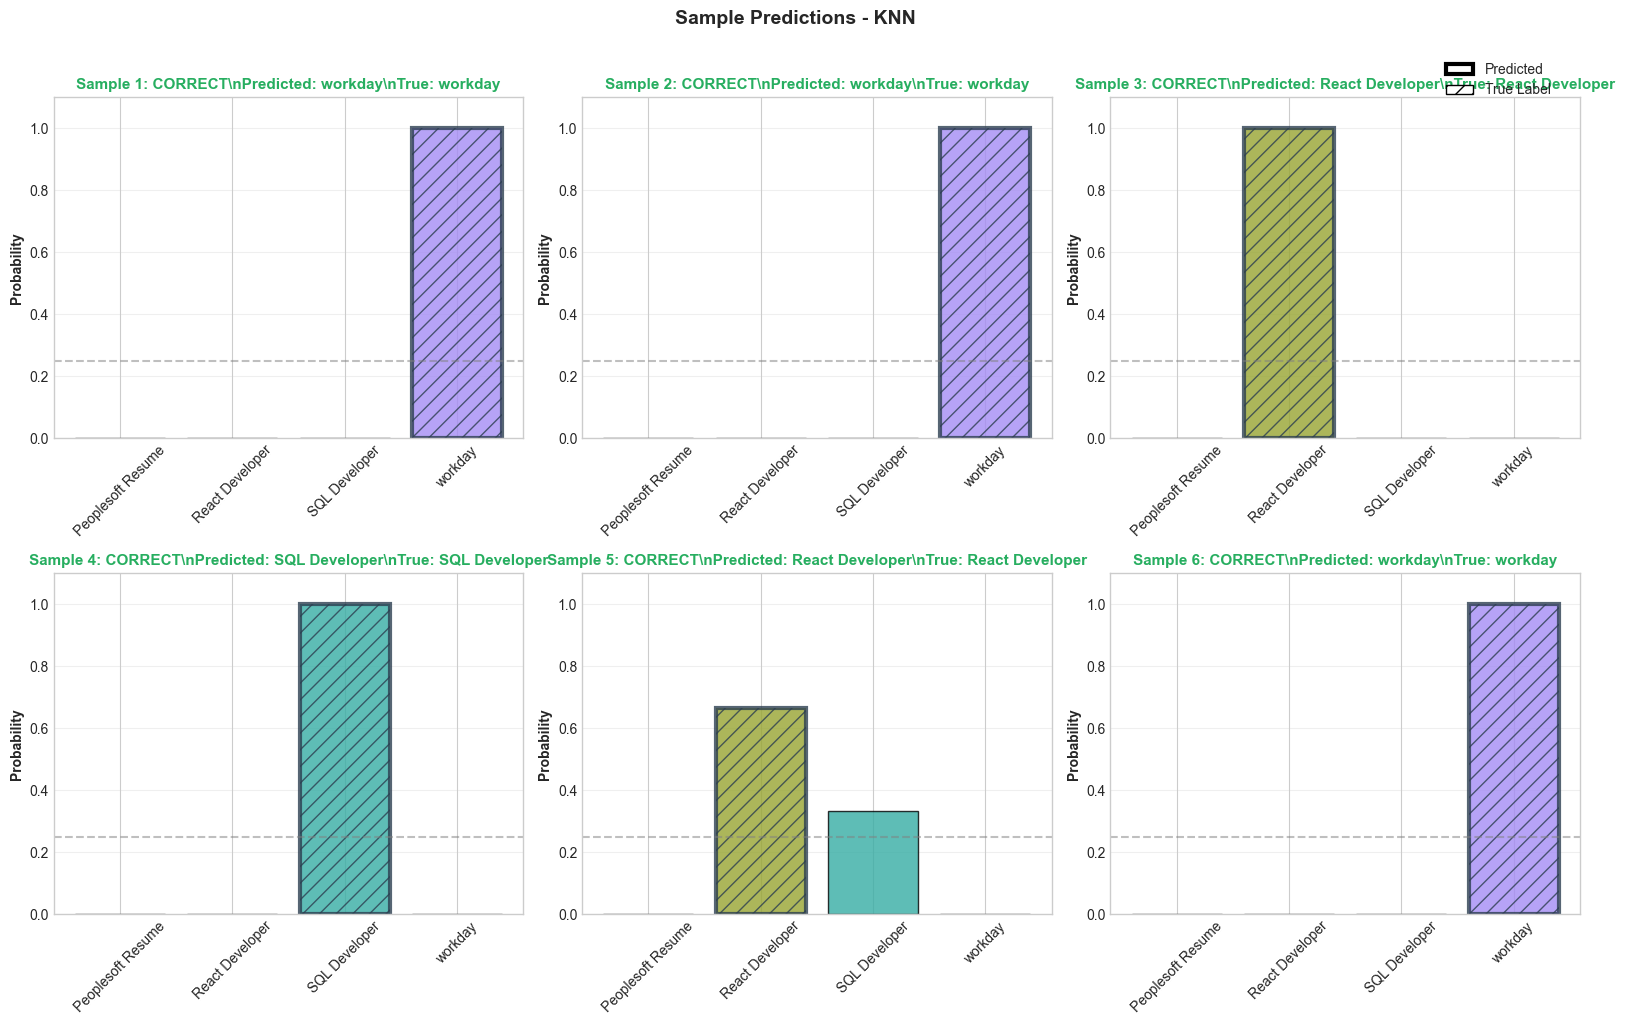


------------------------------------------------------------------------------------------
PREDICTION SUMMARY
------------------------------------------------------------------------------------------
  Samples shown:       6
  Correct predictions: 6/6 (100%)
  Model used:          KNN

Sample predictions demo complete.
Saved: sample_predictions.png


In [27]:
# Sample Predictions Demo
print("=" * 100)
print("SAMPLE PREDICTIONS DEMONSTRATION")
print("=" * 100)

# Load original data to get resume text for display
df_model = pd.read_csv('processed_data/resumes_cleaned.csv')

# Get test indices (map back to original data)
# We'll use random samples from test set
np.random.seed(42)
num_samples = min(6, len(y_test))  # Show up to 6 samples
sample_indices = np.random.choice(len(y_test), num_samples, replace=False)

print(f"\nShowing {num_samples} sample predictions from test set:\n")

for i, test_idx in enumerate(sample_indices, 1):
    # Get prediction details
    true_class = le.classes_[y_test[test_idx]]
    pred_class = le.classes_[y_pred_best[test_idx]]
    proba = y_proba_best[test_idx] if y_proba_best is not None else None
    is_correct = true_class == pred_class
    
    # Get text preview (first 200 characters)
    text_vector = X_test[test_idx]
    
    print(f"{'-' * 90}")
    print(f"  SAMPLE {i}")
    print(f"{'-' * 90}")
    print(f"  True Category:      {true_class}")
    print(f"  Predicted Category: {pred_class} [{'CORRECT' if is_correct else 'INCORRECT'}]")
    
    if proba is not None:
        print(f"\n  Prediction Probabilities:")
        # Sort by probability
        sorted_indices = np.argsort(proba)[::-1]
        for rank, class_idx in enumerate(sorted_indices, 1):
            class_name = le.classes_[class_idx]
            prob = proba[class_idx]
            bar_len = int(prob * 30)
            bar = '-' * bar_len + ' ' * (30 - bar_len)
            marker = ' [PREDICTED]' if class_idx == y_pred_best[test_idx] else ''
            marker = marker if class_idx != y_test[test_idx] else ' [TRUE]'
            if class_idx == y_pred_best[test_idx] == y_test[test_idx]:
                marker = ' [CORRECT]'
            print(f"      {rank}. {class_name:20s} |{bar}| {prob:.4f}{marker}")
    
    print()

# Visualization: Sample predictions grid
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, test_idx in enumerate(sample_indices):
    ax = axes[i]
    
    true_class = le.classes_[y_test[test_idx]]
    pred_class = le.classes_[y_pred_best[test_idx]]
    proba = y_proba_best[test_idx] if y_proba_best is not None else np.ones(len(le.classes_)) / len(le.classes_)
    is_correct = true_class == pred_class
    
    # Bar chart of probabilities
    colors = sns.color_palette('husl', len(le.classes_))
    bars = ax.bar(le.classes_, proba, color=colors, edgecolor='black', alpha=0.8)
    
    # Highlight predicted and true classes
    for bar_idx, (bar, class_name) in enumerate(zip(bars, le.classes_)):
        if class_name == pred_class:
            bar.set_edgecolor('#2c3e50')
            bar.set_linewidth(3)
        if class_name == true_class:
            bar.set_hatch('//')
    
    ax.set_ylabel('Probability', fontweight='bold')
    status = 'CORRECT' if is_correct else 'INCORRECT'
    ax.set_title(f'Sample {i+1}: {status}\\nPredicted: {pred_class}\\nTrue: {true_class}', 
                fontweight='bold', fontsize=11,
                color='#27ae60' if is_correct else '#c0392b')
    ax.set_ylim([0, 1.1])
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5)
    ax.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='white', edgecolor='black', linewidth=3, label='Predicted'),
                   Patch(facecolor='white', edgecolor='black', hatch='//', label='True Label')]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10)

plt.suptitle(f'Sample Predictions - {best_model_name}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(models_dir / 'sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print(f"\n{'-' * 90}")
print(f"PREDICTION SUMMARY")
print(f"{'-' * 90}")
correct_count = sum(1 for idx in sample_indices if y_pred_best[idx] == y_test[idx])
print(f"  Samples shown:       {num_samples}")
print(f"  Correct predictions: {correct_count}/{num_samples} ({100*correct_count/num_samples:.0f}%)")
print(f"  Model used:          {best_model_name}")
print(f"\nSample predictions demo complete.")
print(f"Saved: sample_predictions.png")

---

## Misclassification Analysis

Analyze incorrectly classified samples to understand model limitations and error patterns. This identifies:
- Categories that are frequently confused with each other
- Edge cases and difficult-to-classify samples
- Potential data quality issues or ambiguous samples

In [28]:
# Misclassification Analysis
print("=" * 100)
print("MISCLASSIFICATION ANALYSIS")
print("=" * 100)

# Use best model predictions
y_pred_best = test_results[best_model_name]['predictions']
y_proba_best = test_results[best_model_name]['probabilities']

# Find misclassified samples
misclassified_mask = y_pred_best != y_test
misclassified_indices = np.where(misclassified_mask)[0]
num_misclassified = len(misclassified_indices)
num_correct = len(y_test) - num_misclassified

print(f"\nClassification Summary for {best_model_name}:")
print("-" * 60)
print(f"  Total Test Samples:      {len(y_test)}")
print(f"  Correctly Classified:    {num_correct} ({100*num_correct/len(y_test):.1f}%)")
print(f"  Misclassified:           {num_misclassified} ({100*num_misclassified/len(y_test):.1f}%)")

if num_misclassified > 0:
    print(f"\nMisclassified Samples Details:")
    print("-" * 80)
    print(f"  {'Index':<8} {'True Label':<20} {'Predicted':<20} {'Confidence':<12}")
    print("-" * 80)
    
    # Create dataframe for misclassified samples
    misclass_data = []
    
    for idx in misclassified_indices:
        true_label = le.classes_[y_test[idx]]
        pred_label = le.classes_[y_pred_best[idx]]
        confidence = y_proba_best[idx][y_pred_best[idx]] if y_proba_best is not None else 'N/A'
        conf_str = f"{confidence:.4f}" if isinstance(confidence, float) else confidence
        
        print(f"  {idx:<8} {true_label:<20} {pred_label:<20} {conf_str:<12}")
        
        misclass_data.append({
            'test_idx': idx,
            'true_label': true_label,
            'predicted_label': pred_label,
            'confidence': confidence if isinstance(confidence, float) else None,
            'true_label_prob': y_proba_best[idx][y_test[idx]] if y_proba_best is not None else None
        })
    
    misclass_df = pd.DataFrame(misclass_data)
    
    # Analyze confusion patterns
    print(f"\nConfusion Pattern Analysis:")
    print("-" * 60)
    
    confusion_pairs = misclass_df.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
    confusion_pairs = confusion_pairs.sort_values('count', ascending=False)
    
    print(f"  {'True Label':<20} {'Predicted As':<20} {'Count':<8}")
    print("-" * 60)
    for _, row in confusion_pairs.iterrows():
        print(f"  {row['true_label']:<20} → {row['predicted_label']:<20} {row['count']:<8}")
    
    # Visualization: Misclassification Analysis
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1. Misclassification by True Category
    ax = axes[0, 0]
    misclass_by_true = misclass_df['true_label'].value_counts()
    if len(misclass_by_true) > 0:
        colors = sns.color_palette('Reds_r', len(misclass_by_true))
        bars = ax.bar(misclass_by_true.index, misclass_by_true.values, color=colors, edgecolor='black')
        ax.set_xlabel('True Category', fontweight='bold')
        ax.set_ylabel('Misclassification Count', fontweight='bold')
        ax.set_title('Misclassifications by True Category', fontweight='bold', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        for bar, val in zip(bars, misclass_by_true.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, str(val), 
                   ha='center', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    # 2. Misclassification by Predicted Category
    ax = axes[0, 1]
    misclass_by_pred = misclass_df['predicted_label'].value_counts()
    if len(misclass_by_pred) > 0:
        colors = sns.color_palette('Blues_r', len(misclass_by_pred))
        bars = ax.bar(misclass_by_pred.index, misclass_by_pred.values, color=colors, edgecolor='black')
        ax.set_xlabel('Predicted Category', fontweight='bold')
        ax.set_ylabel('Misclassification Count', fontweight='bold')
        ax.set_title('Misclassifications by Predicted Category', fontweight='bold', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        for bar, val in zip(bars, misclass_by_pred.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, str(val), 
                   ha='center', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    # 3. Confidence Distribution: Correct vs Incorrect
    ax = axes[1, 0]
    if y_proba_best is not None:
        max_proba = np.max(y_proba_best, axis=1)
        correct_conf = max_proba[~misclassified_mask]
        incorrect_conf = max_proba[misclassified_mask]
        
        ax.hist(correct_conf, bins=12, alpha=0.7, label=f'Correct (n={len(correct_conf)})', 
                color='#2ecc71', edgecolor='black')
        ax.hist(incorrect_conf, bins=12, alpha=0.7, label=f'Incorrect (n={len(incorrect_conf)})', 
                color='#e74c3c', edgecolor='black')
        ax.axvline(correct_conf.mean(), color='#27ae60', linestyle='--', linewidth=2, 
                   label=f'Correct Mean: {correct_conf.mean():.3f}')
        if len(incorrect_conf) > 0:
            ax.axvline(incorrect_conf.mean(), color='#c0392b', linestyle='--', linewidth=2, 
                       label=f'Incorrect Mean: {incorrect_conf.mean():.3f}')
        ax.set_xlabel('Prediction Confidence', fontweight='bold')
        ax.set_ylabel('Frequency', fontweight='bold')
        ax.set_title('Confidence Distribution: Correct vs Incorrect', fontweight='bold', fontsize=12)
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)
    
    # 4. Error Rate by Category (percentage)
    ax = axes[1, 1]
    error_rate_data = []
    for cat in le.classes_:
        cat_mask = y_test == le.transform([cat])[0]
        cat_total = cat_mask.sum()
        cat_errors = (misclassified_mask & cat_mask).sum()
        error_rate = (cat_errors / cat_total * 100) if cat_total > 0 else 0
        error_rate_data.append({'category': cat, 'error_rate': error_rate, 
                               'total': cat_total, 'errors': cat_errors})
    
    error_df = pd.DataFrame(error_rate_data)
    colors = plt.cm.RdYlGn_r(error_df['error_rate'] / 100)
    bars = ax.bar(error_df['category'], error_df['error_rate'], color=colors, edgecolor='black')
    ax.set_xlabel('Category', fontweight='bold')
    ax.set_ylabel('Error Rate (%)', fontweight='bold')
    ax.set_title('Error Rate by Category', fontweight='bold', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim([0, max(error_df['error_rate']) * 1.3 if max(error_df['error_rate']) > 0 else 10])
    for bar, row in zip(bars, error_df.itertuples()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
               f'{row.error_rate:.1f}%\n({row.errors}/{row.total})', 
               ha='center', fontsize=9, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(y=100*num_misclassified/len(y_test), color='navy', linestyle='--', 
               linewidth=2, label=f'Overall: {100*num_misclassified/len(y_test):.1f}%')
    ax.legend()
    
    plt.suptitle(f'Misclassification Analysis - {best_model_name}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(models_dir / 'misclassification_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print(f"\nPerfect classification! No misclassified samples on test set.")

print(f"\nMisclassification analysis complete.")

MISCLASSIFICATION ANALYSIS

Classification Summary for KNN:
------------------------------------------------------------
  Total Test Samples:      24
  Correctly Classified:    24 (100.0%)
  Misclassified:           0 (0.0%)

Perfect classification! No misclassified samples on test set.

Misclassification analysis complete.
